# Proyecto Final: Prevención de infartos en asegurados

**Enunciado**

En los enfermos con síndrome coronario agudo atendidos en hospitales la predicción de la muerte y/o infarto de miocardio no fatal en los 6 meses puede realizarse con variables sencillas

Un buen diseño de modelo Machine Learning puede ayudar al paciente con alto riesgo de sufrir un infarto a prevenir tal suceso. Desde un punto de vista empresarial de una empresa de seguros es importante porque previene altos gastos como puede ser: Costos en cuidados intensivos, pago de prima por sufrimiento de infarto entre otros gatos. 

Para lograr esta labor se ha revisado 4 años de otorgación histórica de salud de los clientes asegurados.

**Diccionario de Datos**

|Nombre variable|Descripción|
|----|----|
|ID|Identificador del paciente|
|Genero||
|Edad||
|Flag_hipertension|Flag de enfermedad hipertensión|
|Flag_problem_cardiaco|Flag de problema cardiaco previo|
|Estados_civil||
|Tipo_trabajo||
|Zona_residencia|Rural o Urbana|
|Promedio_nivel_glucosa||
|IMC||
|Flag_fumador|Flag fumador|
|Ataque_cardiaco||

In [1661]:
# Carga de librerías
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scorecardpy as sc
import warnings
warnings.filterwarnings("ignore")
from time import time
from IPython.display import Image
from causalgraphicalmodels import CausalGraphicalModel

import statsmodels.api as sm
from scipy.stats import normaltest,chi2_contingency
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold
from sklearn.metrics import make_scorer, recall_score
from sklearn.metrics import (accuracy_score, recall_score, precision_score, f1_score, 
                             confusion_matrix,roc_curve,roc_auc_score,auc, RocCurveDisplay)
import optuna
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier
from lightgbm import LGBMClassifier
from xgboost import XGBClassifier

In [1537]:
df = pd.read_csv('2_DS_train_enf_corazon.csv',sep=';')

df.head()

,ID,Genero,Edad,Flag_hipertension,Flag_problem_cardiaco,Estados_civil,Tipo_trabajo,Zona_residencia,Promedio_nivel_glucosa,IMC,Flag_fumador,Ataque_cardiaco
0,30669,Hombre,3.0,0,0,No,cuidar_ninos,Rural,95.12,18.0,NaN,0
1,30468,Hombre,58.0,1,0,Si,Empresa_privada,Urbano,87.96,39.2,Nunca_fuma,0
2,16523,Mujer,8.0,0,0,No,Empresa_privada,Urbano,110.89,17.6,NaN,0
3,56543,Mujer,70.0,0,0,Si,Empresa_privada,Rural,69.04,35.9,antes_fumaba,0
4,46136,Hombre,14.0,0,0,No,Nunca_trabajo,Rural,161.28,19.1,NaN,0


## 1. Descripción General del Dataset

In [1538]:
df.shape

(43400, 12)

In [1539]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 43400 entries, 0 to 43399
Data columns (total 12 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   ID                      43400 non-null  int64  
 1   Genero                  43400 non-null  object 
 2   Edad                    43400 non-null  float64
 3   Flag_hipertension       43400 non-null  int64  
 4   Flag_problem_cardiaco   43400 non-null  int64  
 5   Estados_civil           43400 non-null  object 
 6   Tipo_trabajo            43400 non-null  object 
 7   Zona_residencia         43400 non-null  object 
 8   Promedio_nivel_glucosa  43400 non-null  float64
 9   IMC                     41938 non-null  float64
 10  Flag_fumador            30108 non-null  object 
 11  Ataque_cardiaco         43400 non-null  int64  
dtypes: float64(3), int64(4), object(5)
memory usage: 4.0+ MB


In [1540]:
def validar_faltantes(df):

    cols_faltantes = pd.DataFrame(df.isnull().sum()[df.isnull().sum()>0].reset_index())

    print('Columnas con datos faltantes:',len(cols_faltantes))

    cols_faltantes.columns = ['variable','nulos']
    cols_faltantes['%'] = (cols_faltantes['nulos'] / df.shape[0]).round(2)

    return cols_faltantes.sort_values(by='%',ascending=False)

In [1541]:
validar_faltantes(df)

Columnas con datos faltantes: 2


,variable,nulos,%
1,Flag_fumador,13292,0.31
0,IMC,1462,0.03


In [1542]:
df.duplicated().sum()

0

**Hallazgo**
- Dentro del dataset contamos con 12 variables y 43400 registros.
- De las 12 variables, 7 son numéricas y 5 del tipo categóricas.
- Se puede apreciar que tenemos dos columnas con datos faltantes (**IMC** y **Flag_fumador**).
- La columna **Flag_fumador** presenta un nivel muy alto de faltantes (aproximadamente un 31%), por lo que podríamos considerar su no inclusión.
- La columna **IMC** tiene un nivel muy bajo (3%). Al ser una variable numérica, podemos considerar alguna técnica de imputación por mediana.
- No contamos con valores duplicados.

In [1543]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
ID,43400.0,36326.142350,21072.134879,1.00,18038.50,36351.50,54514.25,72943.00
Edad,43400.0,42.217894,22.519649,0.08,24.00,44.00,60.00,82.00
Flag_hipertension,43400.0,0.093571,0.291235,0.00,0.00,0.00,0.00,1.00
Flag_problem_cardiaco,43400.0,0.047512,0.212733,0.00,0.00,0.00,0.00,1.00
Promedio_nivel_glucosa,43400.0,104.482750,43.111751,55.00,77.54,91.58,112.07,291.05
IMC,41938.0,28.605038,7.770020,10.10,23.20,27.70,32.90,97.60
Ataque_cardiaco,43400.0,0.018041,0.133103,0.00,0.00,0.00,0.00,1.00


**Hallazgo**
- El comportamiento de la variable ID corresponde a una variable de identificación, por lo que podríamos considerar su eliminación.
- La media de la edad de los clientes ronda los 42.2 años. Asimismo, la mediana de la edad es muy cercana, rondando los 44 años.
- Con respecto a **Flag_hipertension**: Aproximadamente un 9% de los clientes tiene hipertensión. Esto se ve reflejado en que la media de los datos, además de que los valores inferiores al percentil 75 son 0
- Asimismo, respecto a la variable **Flag_problem_cardiaco"**: Aproximadamente solo un 5% está registrado como si tuviera problemas cardiacos.
- La media de la variable **Promedio_nivel_glucosa** ronda las 104 unidades. Sin embargo, podemos ver que hay un máximo de 291, lo que nos podría indicar presencia de valores atípicos.
- De manera similar, en **IMC** tenemos un valor máximo de 97.60, cuando la media y mediana rondan los 27-28.
- Podemos ver que la variable **Ataque_cardiaco** tiene solo un 1.8% de casos positivos, lo que habla de un desbalance muy marcado.
- Dado el caso planteado en el enunciado, nuestra variable objetivo será **Ataque_cardiaco**, por lo que se tendrán que utilizar técnicas de balanceo de datos.

## 2. Análisis Exploratorio de Datos

### 2.1. Análisis Univariado

#### 2.1.1. Variable Objetivo - Ataque Cardiaco

In [1544]:
def grafico_barras_binarias(col,df,ancho=8,alto=6):

    valores = list(df[col].unique())

    # Imprimir las frecuencias absolutas y relativas
    value_counts = df[col].value_counts()
    percentages = df[col].value_counts(normalize=True) * 100
    freq_table = pd.DataFrame({'Frecuencia': value_counts, 'Porcentaje (%)': percentages})
    print(freq_table)
    
    sns.set(rc={'figure.figsize':(ancho,alto)})
    
    # Total de Filas
    num_total = len(df[col])
    
    # Total de valores iguales a 1
    num_true = len(df[df[col]==valores[0]])
    num_false = len(df[df[col]==valores[1]])

    #
    plt.bar([f"Valor = {valores[1]} ({round((num_false / num_total) * 100,2)} %)", f"Valor = {valores[0]} ({round((num_true / num_total) * 100,2)} %)"],  # Etiquetas
            [num_false, num_true],  # Valores
            color=["salmon", "skyblue"],          
            width=0.8)                      
    
    plt.ylabel("Total")
    plt.show()

In [1545]:
def grafico_barras(col,df_temp,ancho=8,alto=6):
  
    df = df_temp.copy()
    
    sns.set(rc={'figure.figsize':(ancho,alto)})

    # Validar si la columna existe
    if col not in df.columns:
        print(f"La columna '{col}' no existe en el DataFrame.")
        return
    
    # Si la columna es categórica, agregar 'Nulos' como categoría si es necesario
    if pd.api.types.is_categorical_dtype(df[col]):
        if 'Nulos' not in df[col].cat.categories:
            df[col] = df[col].cat.add_categories('Nulos')
    
    # Rellenar valores nulos
    df[col] = df[col].fillna('Nulos') if pd.api.types.is_categorical_dtype(df[col]) else df[col].fillna('Nulos')
    
    # Imprimir las frecuencias absolutas y relativas
    value_counts = df[col].value_counts()
    percentages = df[col].value_counts(normalize=True) * 100
    freq_table = pd.DataFrame({'Frecuencia': value_counts, 'Porcentaje (%)': percentages})
    print(freq_table)
        
    # Ordenar los valores de la columna de forma descendente
    ordered_col = df[col].value_counts().index

    # Crear el gráfico de barras con los valores ordenados
    ax = sns.countplot(x=col, data=df, order=ordered_col, color='skyblue')

    total = len(df[col])  # Longitud total de la columna
    for p in ax.patches:
        percentage = '{:.1f}%'.format(100 * p.get_height() / total)  # Calcular el porcentaje
        x = p.get_x() + p.get_width() / 2 - 0.1  # Posición en el eje x
        y = p.get_y() + p.get_height()           # Posición en el eje y
        ax.annotate(percentage, (x, y), size=14)  # Anotar el porcentaje

    plt.show() 

In [1546]:
def grafico_histograma(col,df,bins=25,ancho=8,alto=6):

    print(df[col].describe())
        
    sns.set(rc={'figure.figsize':(ancho,alto)})

    sns.histplot(df[col], color='skyblue', bins=bins)
    plt.show()

In [1547]:
def identificar_outliers(col,df):

    Q1 = df[col].quantile(0.25)
    Q3 = df[col].quantile(0.75)

    IQR = Q3 - Q1 

    upper_whisker = Q3 + 1.5 * IQR
    lower_whisker = Q1 - 1.5 * IQR

    outliers = df[(df[col] < lower_whisker) | (df[col] > upper_whisker)]

    print(f"Columna: {col}")
    print(f"Q1 = {Q1:.2f}, Q3 = {Q3:.2f}, IQR = {IQR:.2f}")
    print(f"Límite inferior = {lower_whisker:.2f}, superior = {upper_whisker:.2f}")
    print(f"Outliers detectados: {len(outliers)} ({len(outliers)/len(df)*100:.2f}%)")

    return outliers

                 Frecuencia  Porcentaje (%)
Ataque_cardiaco                            
0                     42617       98.195853
1                       783        1.804147


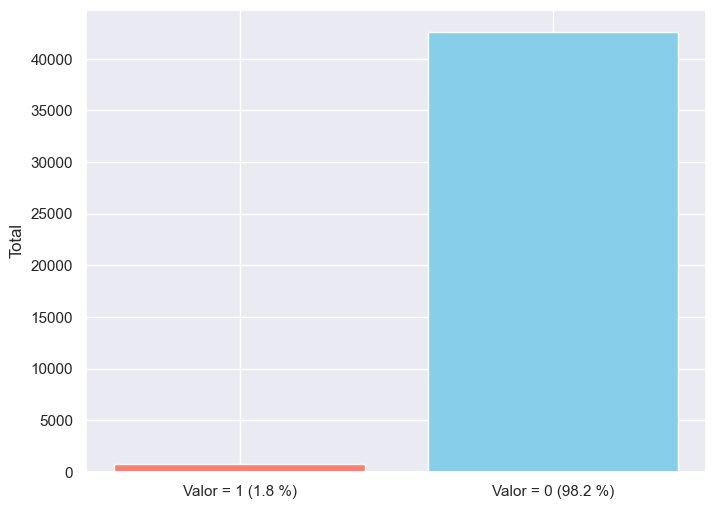

In [1548]:
grafico_barras_binarias('Ataque_cardiaco',df)

**Hallazgo**
- Nuestra variable objetivo presenta un nivel de desbalance muy elevado. 
- Por lo tanto, será necesario aplicar técnicas de balanceo de datos para el desarrollo del modelo.

#### 2.1.2. ID

count    43400.000000
mean     36326.142350
std      21072.134879
min          1.000000
25%      18038.500000
50%      36351.500000
75%      54514.250000
max      72943.000000
Name: ID, dtype: float64


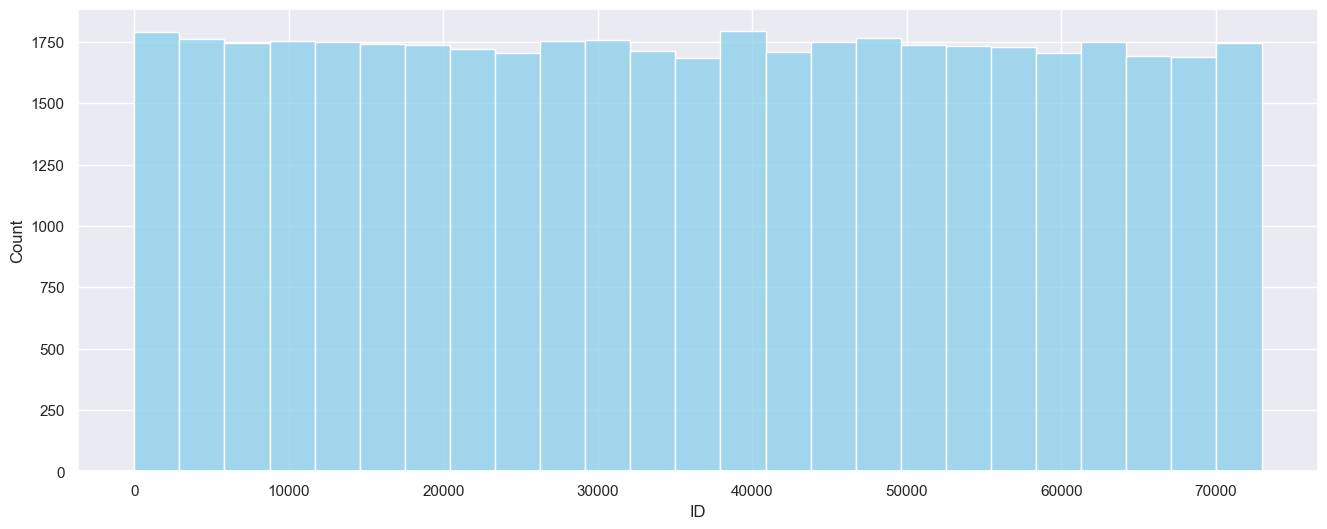

In [1549]:
grafico_histograma('ID',df,ancho=16)

In [1550]:
df['ID'].duplicated().sum()

0

**Hallazgos**
- La variable ID corresponde a la identificación del cliente, sin aportar datos intrínsecos de dicho cliente. 
- Además no tiene duplicados, por lo que todos los registros sin diferentes. Esto significa que la variable tiene un bajo poder predictivo
- Esta variable se descartaría para el desarrollo del modelo.

### 2.1.3. Genero

        Frecuencia  Porcentaje (%)
Genero                            
Mujer        25665       59.135945
Hombre       17724       40.838710
Other           11        0.025346


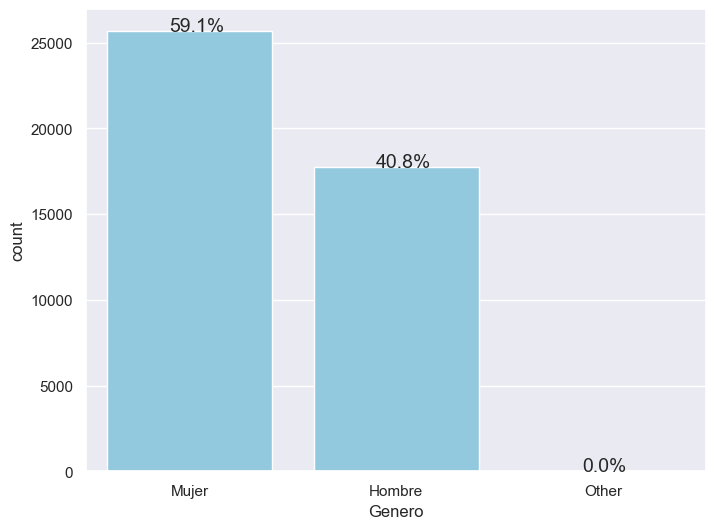

In [1551]:
grafico_barras('Genero',df)

**Hallazgos**
- Se puede apreciar una mayor presencia de las mujeres dentro del dataset. 
- Además, el grupo Otros representa menos del 0.01%, por lo que podríamos considerar agruparlo en alguna de las otras categorías, dependiendo del comportamiento de ambos grupos respecto a la variable objetivo.

### 2.1.4. Edad

count    43400.000000
mean        42.217894
std         22.519649
min          0.080000
25%         24.000000
50%         44.000000
75%         60.000000
max         82.000000
Name: Edad, dtype: float64


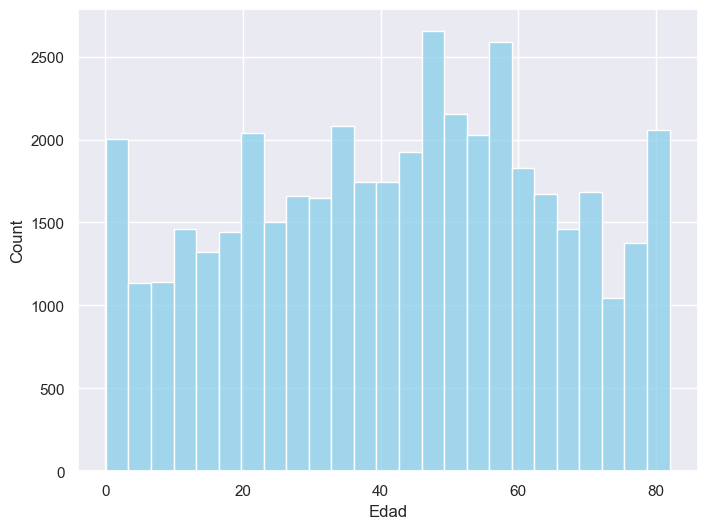

In [1552]:
grafico_histograma('Edad',df)

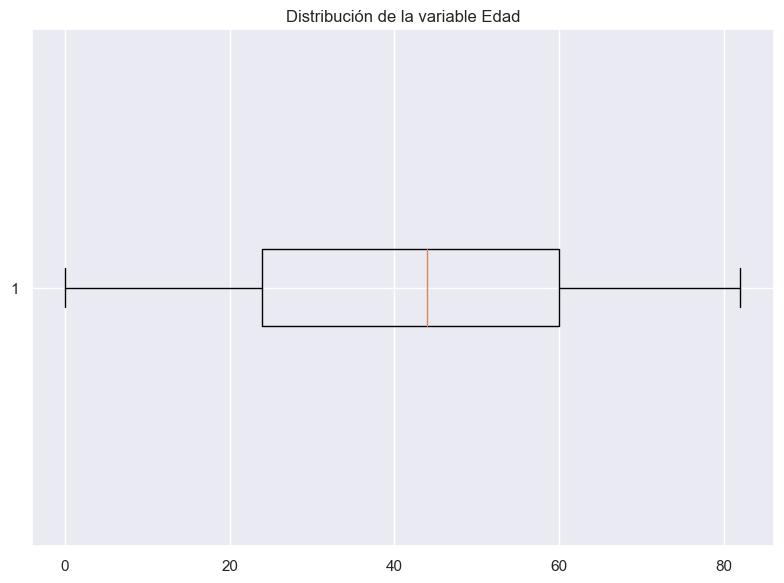

In [1553]:
plt.boxplot(df['Edad'],vert=False)
plt.title('Distribución de la variable Edad')
plt.tight_layout()
plt.show()

In [1554]:
# Validamos si la distribución es normal
stat, p = normaltest(df['Edad'])

print('Prueba D-Agostino K2')
print(f" p = {p:.4f}")

Prueba D-Agostino K2
 p = 0.0000


**Hallazgos**
- Podemos apreciar una distribución **platicúrtica**: No hay un pico muy pronunciado.
- Tampoco presenta outliers (frecuente en este tipo de distribuciones)
- Finalmente, según los resultados de la prueba de normalidad, no hay evidencia para asumir normalidad de la distribución.

### 2.1.5. Flag_hipertension

                   Frecuencia  Porcentaje (%)
Flag_hipertension                            
0                       39339       90.642857
1                        4061        9.357143


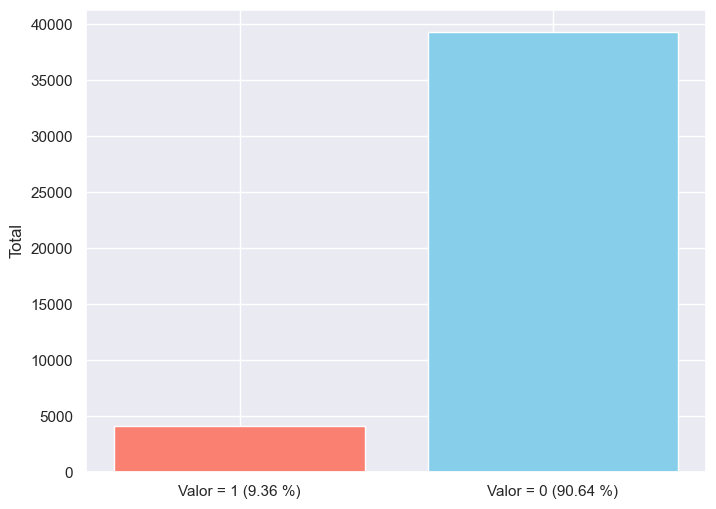

In [1555]:
grafico_barras_binarias('Flag_hipertension',df)

**Hallazgos**
- Vemos una distribución muy desbalanceada: Solo el 9.36% de los clientes sufren de hipertensión.
- Se requiere evaluar el impacto de esta variable respecto a la variable objetivo.

### 2.1.6. Flag_problem_cardiaco

                       Frecuencia  Porcentaje (%)
Flag_problem_cardiaco                            
0                           41338       95.248848
1                            2062        4.751152


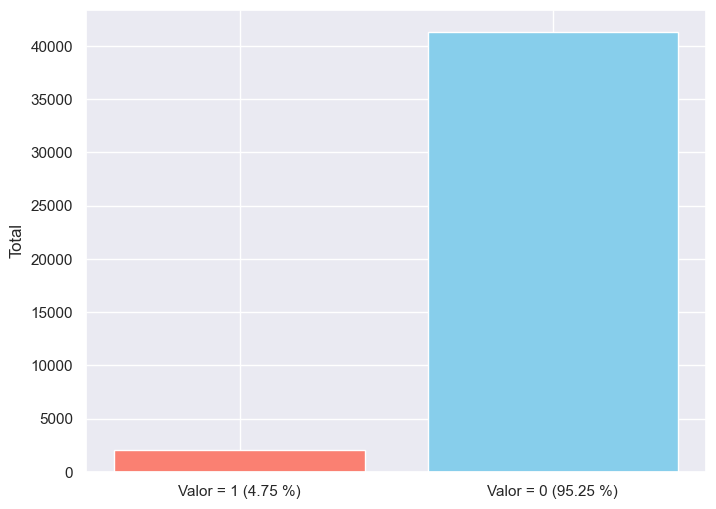

In [1556]:
grafico_barras_binarias('Flag_problem_cardiaco',df)

**Hallazgos**
- Al igual que la variable de Hipertención, vemos una distribución muy desbalanceada en la variable de Problemas Cardiacos: Solo el 4.75% de los clientes presentan problemas de este tipo.

### 2.1.7. Estados_civil

               Frecuencia  Porcentaje (%)
Estados_civil                            
Si                  27938       64.373272
No                  15462       35.626728


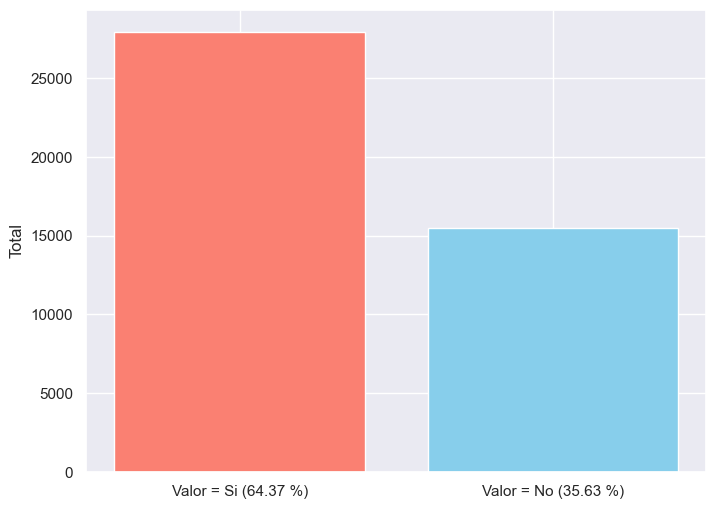

In [1557]:
grafico_barras_binarias('Estados_civil',df)

**Hallazgos**
- En esta gráfica podemos concluir que la mayor parte de los clientes son casaddos (aproximadamente las dos terceras partes del total)

### 2.1.8. Tipo_trabajo

                 Frecuencia  Porcentaje (%)
Tipo_trabajo                               
Empresa_privada       24834       57.221198
Emprendedor            6793       15.652074
cuidar_ninos           6156       14.184332
En_gobierno            5440       12.534562
Nunca_trabajo           177        0.407834


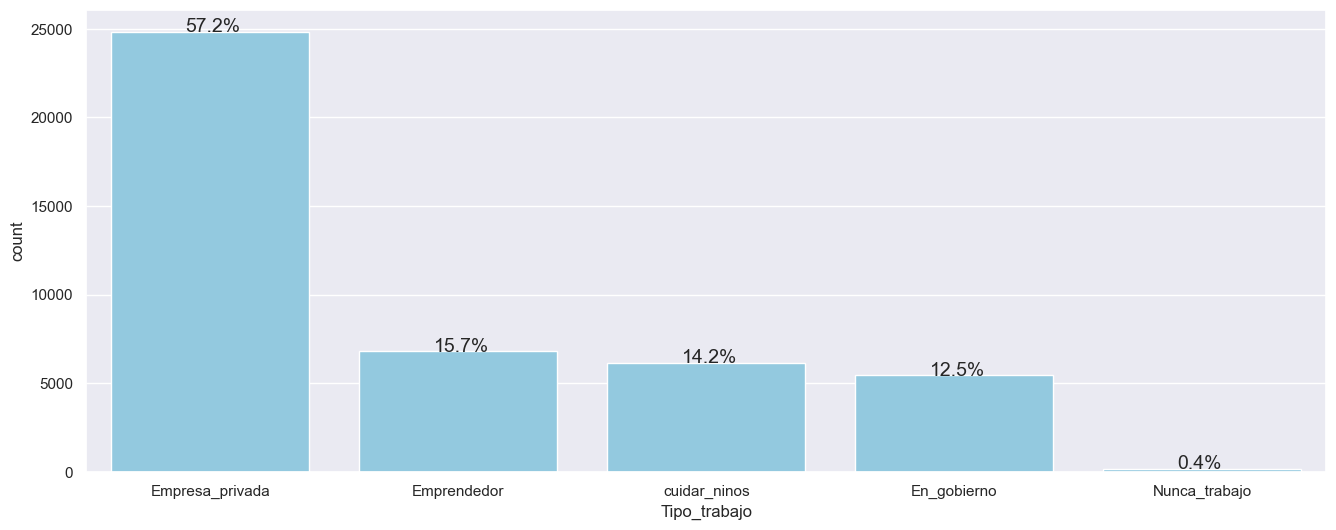

In [1558]:
grafico_barras('Tipo_trabajo',df,ancho=16)

**Hallazgos**
- Más de la mitad de la distribución de clientes trabajan en empresas privadas.
- Las demás categorías no llegan al 16% de los clientes.
- Asimismo, un 0.4% de clientes no trabajan. Al ser una categoría con muy poca representación, podríamos considerar agruparla con otra categoría.

### 2.1.9. Zona_residencia

                 Frecuencia  Porcentaje (%)
Zona_residencia                            
Urbano                21756       50.129032
Rural                 21644       49.870968


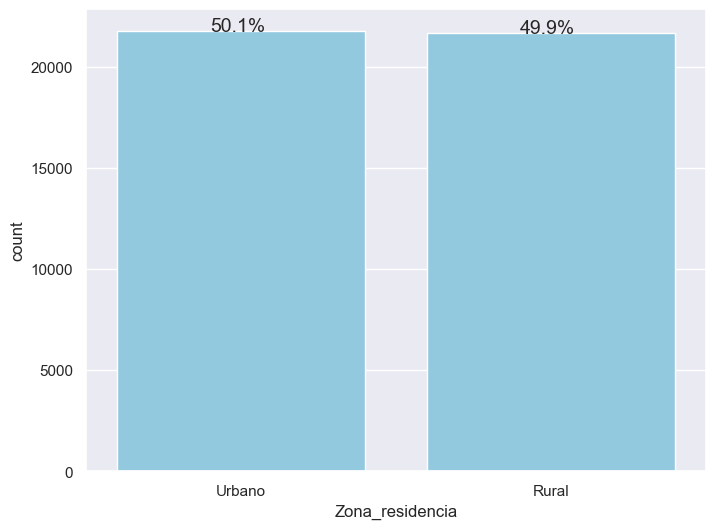

In [1559]:
grafico_barras('Zona_residencia',df)

**Hallazgos**
- La distribución entre urbano y rural está bastante equilibrada. 
- Conviene evaluar el impacto de esta variable respecto a la variable objetivo.

### 2.1.10. Promedio_nivel_glucosa

count    43400.000000
mean       104.482750
std         43.111751
min         55.000000
25%         77.540000
50%         91.580000
75%        112.070000
max        291.050000
Name: Promedio_nivel_glucosa, dtype: float64


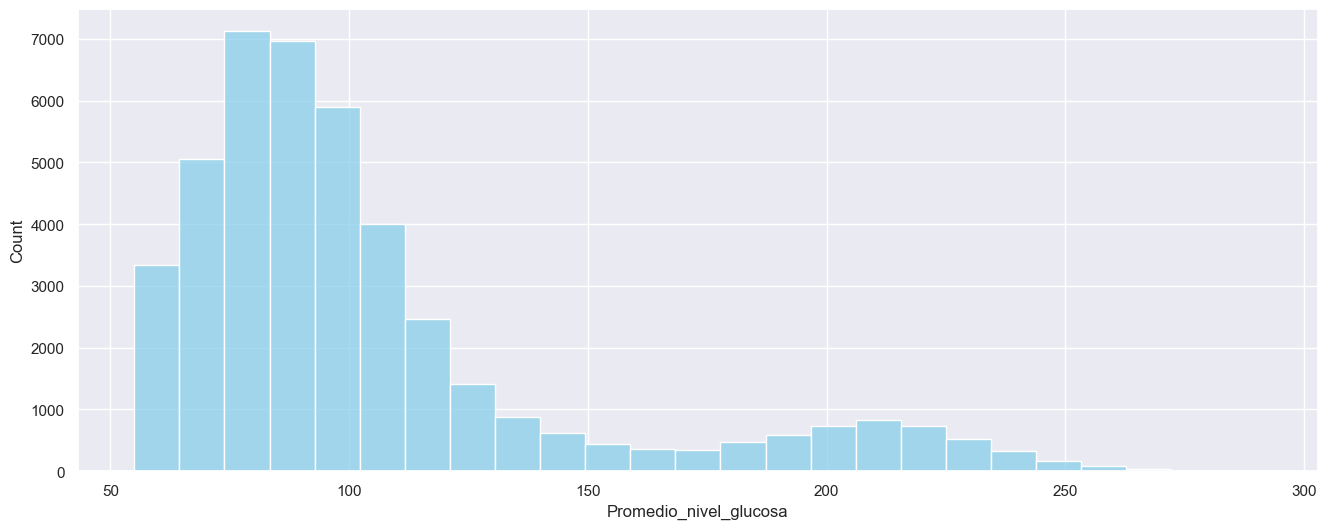

In [1560]:
grafico_histograma('Promedio_nivel_glucosa',df,ancho=16)

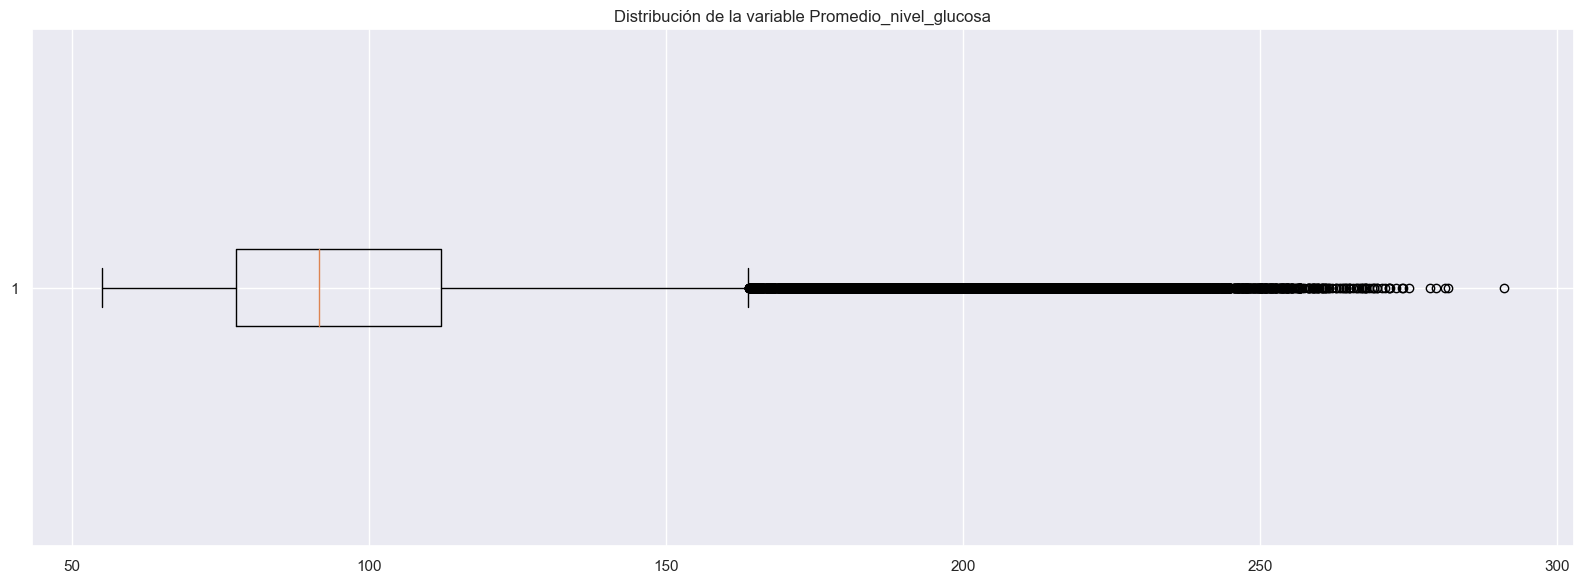

In [1561]:
plt.boxplot(df['Promedio_nivel_glucosa'],vert=False)
plt.title('Distribución de la variable Promedio_nivel_glucosa')
plt.tight_layout()
plt.show()

In [1562]:
identificar_outliers('Promedio_nivel_glucosa',df)

Columna: Promedio_nivel_glucosa
Q1 = 77.54, Q3 = 112.07, IQR = 34.53
Límite inferior = 25.75, superior = 163.86
Outliers detectados: 4978 (11.47%)


,ID,Genero,Edad,Flag_hipertension,Flag_problem_cardiaco,Estados_civil,Tipo_trabajo,Zona_residencia,Promedio_nivel_glucosa,IMC,Flag_fumador,Ataque_cardiaco
5,32257,Mujer,47.0,0,0,Si,Empresa_privada,Urbano,210.95,50.1,NaN,0
7,41413,Mujer,75.0,0,1,Si,Emprendedor,Rural,243.53,27.0,Nunca_fuma,0
9,28674,Mujer,74.0,1,0,Si,Emprendedor,Urbano,205.84,54.6,Nunca_fuma,0
23,4057,Hombre,71.0,0,0,Si,Empresa_privada,Urbano,198.21,27.3,antes_fumaba,0
28,36275,Mujer,54.0,0,0,Si,Empresa_privada,Rural,206.72,26.7,Nunca_fuma,0
...,...,...,...,...,...,...,...,...,...,...,...,...
43381,57176,Hombre,45.0,0,0,Si,Empresa_privada,Urbano,214.05,40.5,antes_fumaba,0
43384,44814,Mujer,65.0,0,0,Si,Empresa_privada,Rural,200.92,30.7,antes_fumaba,0
43388,31321,Mujer,64.0,1,0,Si,En_gobierno,Rural,228.43,NaN,fumador,0
43390,10096,Mujer,69.0,0,0,Si,Emprendedor,Urbano,229.85,31.2,Nunca_fuma,0


**Hallazgos**
- Se puede apreciar una distribución ligeramente bimodal: El pico más importante está rondando las 80-90 unidades. 
- Además, se vuelve a elevar rondando las 200 unidades de glucosa.
- Se puede notar una alta presencia de outliers, producto de la forma de esta distribución. Se tendrá que evaluar técnicas para reducir el impacto de estos valores.

### 2.1.11. IMC

count    41938.000000
mean        28.605038
std          7.770020
min         10.100000
25%         23.200000
50%         27.700000
75%         32.900000
max         97.600000
Name: IMC, dtype: float64


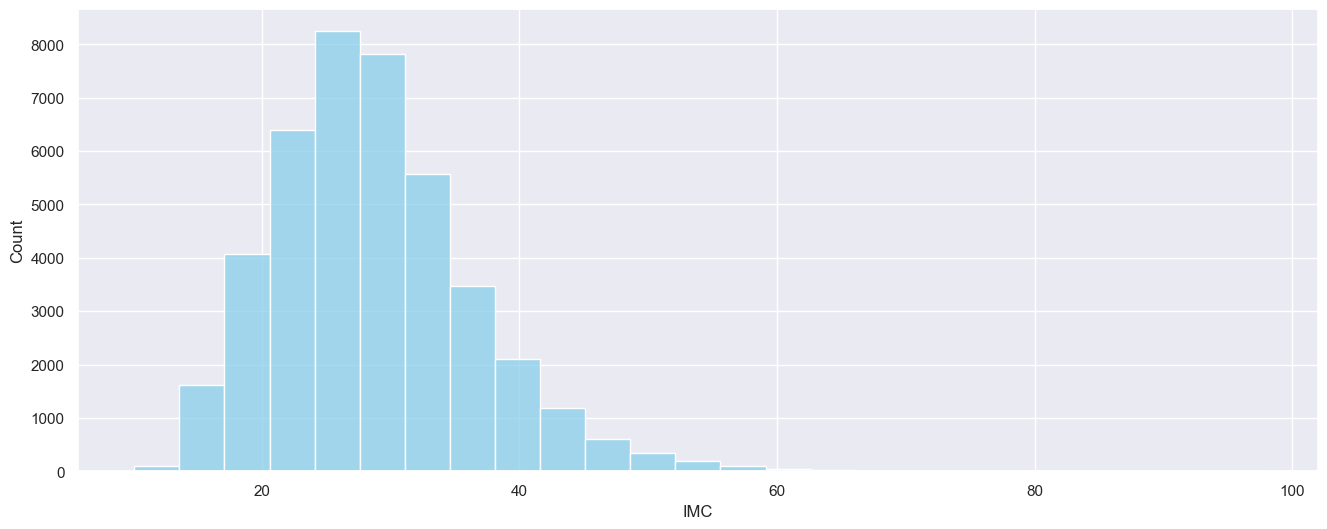

In [1563]:
grafico_histograma('IMC',df,ancho=16)

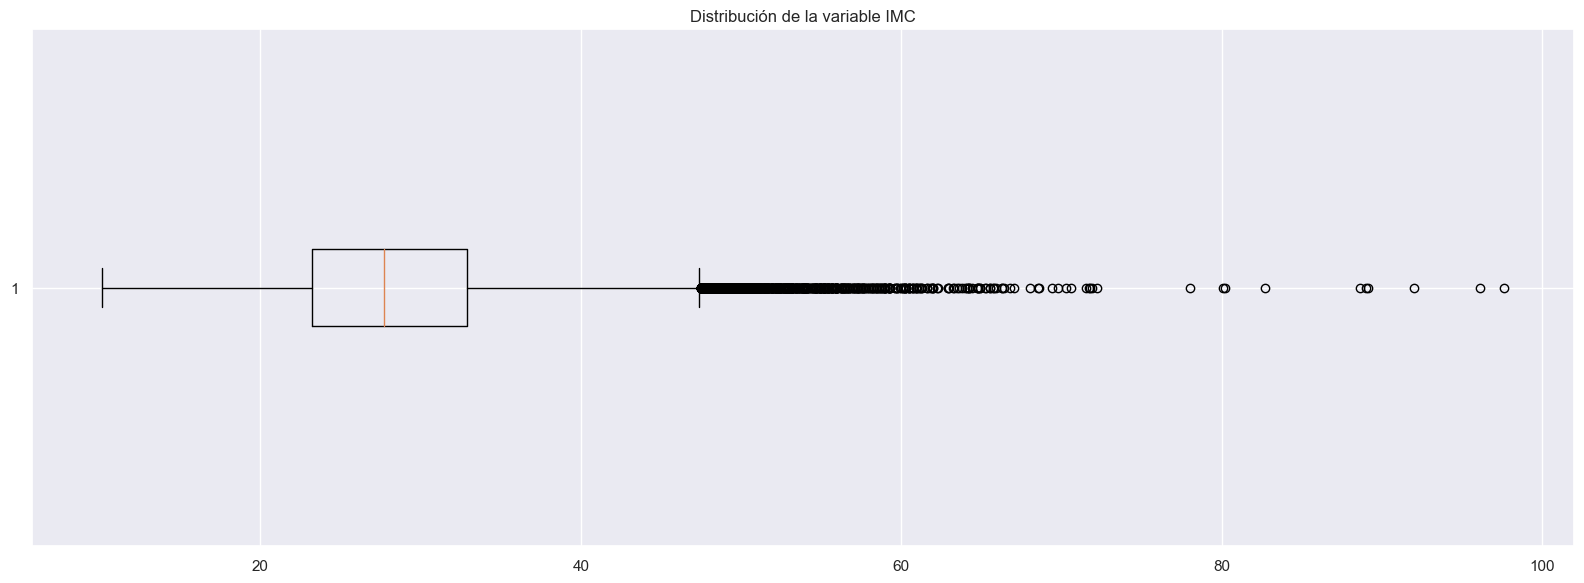

In [1564]:
plt.boxplot(df['IMC'].dropna(),vert=False)
plt.title('Distribución de la variable IMC')
plt.tight_layout()
plt.show()

In [1565]:
identificar_outliers('IMC',df)

Columna: IMC
Q1 = 23.20, Q3 = 32.90, IQR = 9.70
Límite inferior = 8.65, superior = 47.45
Outliers detectados: 888 (2.05%)


,ID,Genero,Edad,Flag_hipertension,Flag_problem_cardiaco,Estados_civil,Tipo_trabajo,Zona_residencia,Promedio_nivel_glucosa,IMC,Flag_fumador,Ataque_cardiaco
5,32257,Mujer,47.0,0,0,Si,Empresa_privada,Urbano,210.95,50.1,NaN,0
9,28674,Mujer,74.0,1,0,Si,Emprendedor,Urbano,205.84,54.6,Nunca_fuma,0
21,72911,Mujer,57.0,1,0,Si,Empresa_privada,Rural,129.54,60.9,fumador,0
86,1703,Mujer,52.0,0,0,Si,Empresa_privada,Urbano,82.24,54.7,antes_fumaba,0
94,38805,Mujer,37.0,0,0,Si,Empresa_privada,Rural,75.18,48.2,antes_fumaba,0
...,...,...,...,...,...,...,...,...,...,...,...,...
43140,45966,Hombre,55.0,0,0,Si,En_gobierno,Urbano,259.23,58.1,NaN,0
43188,35518,Hombre,72.0,0,0,Si,Empresa_privada,Urbano,252.51,54.7,antes_fumaba,0
43239,36167,Hombre,21.0,0,0,No,Empresa_privada,Urbano,83.78,54.9,Nunca_fuma,0
43355,57237,Mujer,46.0,0,0,Si,Empresa_privada,Rural,99.81,53.2,NaN,0


**Hallazgos**
- Se puede apreciar una cola considerablemente sesgada a la derecha.
- Además, se detecta una presencia importante de outliers.

### 2.1.11. Flag_fumador

              Frecuencia  Porcentaje (%)
Flag_fumador                            
Nunca_fuma         16053       36.988479
Nulos              13292       30.626728
antes_fumaba        7493       17.264977
fumador             6562       15.119816


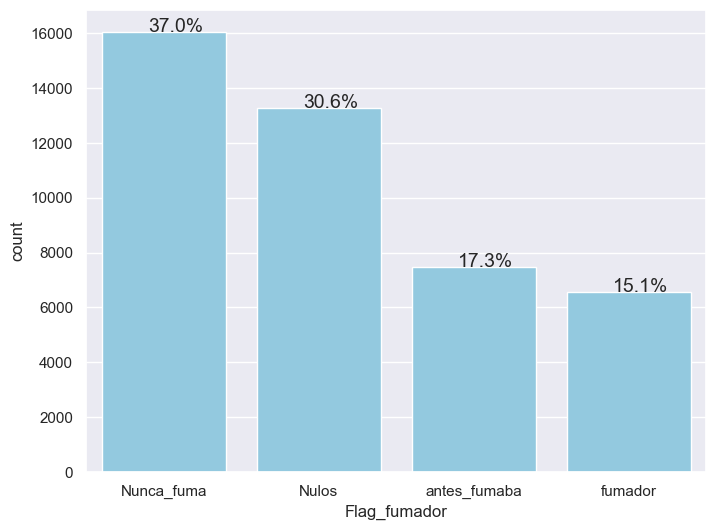

In [1566]:
grafico_barras('Flag_fumador',df)

**Hallazgos**
- Se puede apreciar 4 categorías de las cuales ninguna es muy dominante, así como tampoco tenemos categorías muy poco representadas (menor al 5%)

## 2.2. Análisis Bivariado

In [1567]:
def calcular_iv(col,target='Ataque_cardiaco',df=df,lista_cat=None,generar_col=False):

    """
    Calcula el IV de una columna.
    
    Args:
        col (str): Columna a evaluar.
        df (DataFrame): DataFrame que contiene la columna y el target.
        target (str): Nombre de la columna objetivo.
        lista_cat (dict): Opcional. Son bins personalizados que permiten haer una mejor categorización de los datos, si es que los valores por defecto no son satisfactorios

    """

    if lista_cat is None:
        bins = sc.woebin(df[[col, target]], y=target)
    else:
        bins = sc.woebin(df[[col, target]], y=target, breaks_list={col: lista_cat})
        
    print(bins[col])
    iv = bins[col]['total_iv'].iloc[0]
    print(f"\nIV de la columna {col}: {iv}")

   
    # Graficar los bins
    plt.figure(figsize=(16,6))
    sc.woebin_plot(bins[col])
    plt.show()

### 3.1. Genero

[INFO] creating woe binning ...
  variable     bin  count  count_distr   good  bad   badprob       woe  \
0   Genero  Hombre  17724     0.408387  17372  352  0.019860  0.096743   
1   Genero   Mujer  25665     0.591359  25234  431  0.016793 -0.074112   
2   Genero   Other     11     0.000253     11    0  0.000000  1.492471   

     bin_iv  total_iv  breaks  is_special_values  
0  0.004006  0.008469  Hombre              False  
1  0.003135  0.008469   Mujer              False  
2  0.001328  0.008469   Other              False  

IV de la columna Genero: 0.008468716220107614


<Figure size 1600x600 with 0 Axes>

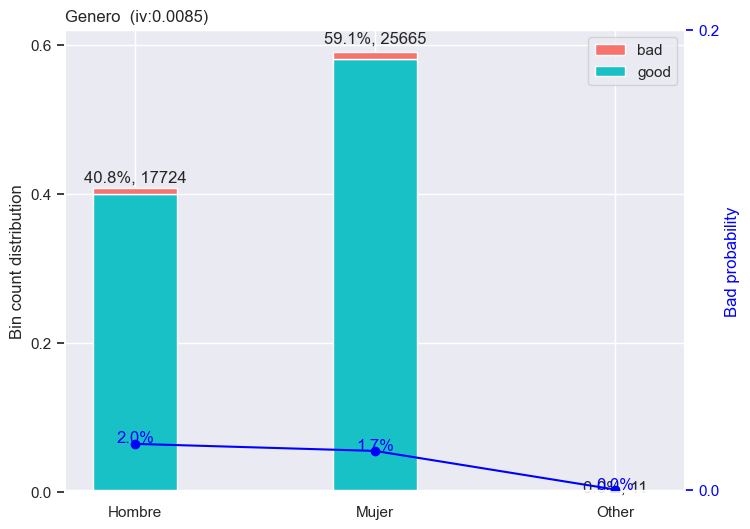

In [1568]:
calcular_iv('Genero',lista_cat=list(df['Genero'].unique()))

**Hallazgos**
- No se ven diferencias muy representativas entre los 3 grupos.
- El IV es bastante bajo, por lo que esta variable tendría un bajo nivel predictivo para con la variable objetivo.
- Se puede evaluar agrupar Other con la categoría mujer (ya que es la categoría con menor probabilidad entre las dos categorías dominantes) con la finalidad de no incluir dummies con tan poca representatividad

### 3.2. Edad

[INFO] creating woe binning ...
  variable          bin  count  count_distr   good  bad   badprob       woe  \
0     Edad  [-inf,34.0)  15865     0.365553  15859    6  0.000378 -3.882857   
1     Edad  [34.0,50.0)   9639     0.222097   9579   60  0.006225 -1.076108   
2     Edad  [50.0,66.0)  10266     0.236544  10059  207  0.020164  0.113372   
3     Edad   [66.0,inf)   7630     0.175806   7120  510  0.066841  1.360624   

     bin_iv  total_iv breaks  is_special_values  
0  1.415168  2.236708   34.0              False  
1  0.159416  2.236708   50.0              False  
2  0.003212  2.236708   66.0              False  
3  0.658911  2.236708    inf              False  

IV de la columna Edad: 2.2367075687624043


<Figure size 1600x600 with 0 Axes>

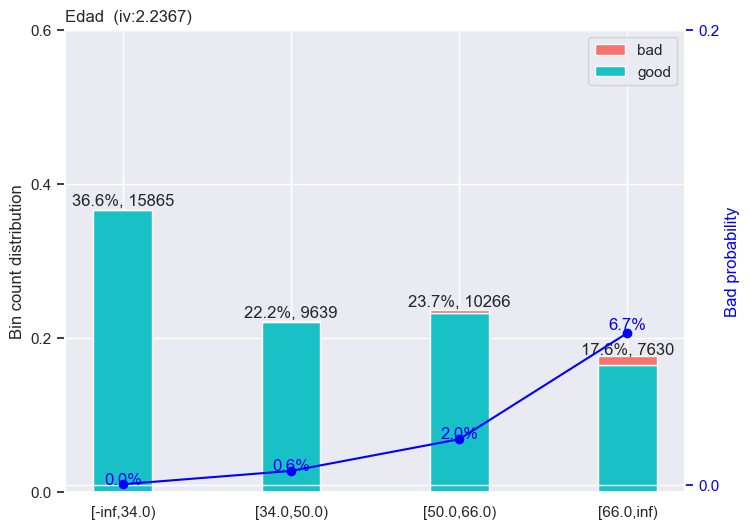

In [1569]:
calcular_iv('Edad')

**Hallazgos**
- En esta gráfica podemos ver que los clientes menores de 34 años prácticamente no tienen problemas cardiacos.
- A partir de los 34 años, ya empiezan a tener problemas de ataque cardiaco.
- Esta tendencia se mantiene para los clientes que superan los 50 años, con una probabilidad del 2%
- Finalmente, la probabilidad de un ataque cardiaco es mucho más alta a partir de los 66 años.
- El **Information Value** es bastante alto (2.2367), por lo que esta variable tiene un alto poder predictivo para con la variable objetivo.
- Se podría considerar la posibilidad de categorizar esta variable basado en los criterios explicados anteriormente.

### 3.3. Flag_hipertension

[INFO] creating woe binning ...
            variable         bin  count  count_distr   good  bad   badprob  \
0  Flag_hipertension  [-inf,1.0)  39339     0.906429  38756  583  0.014820   
1  Flag_hipertension   [1.0,inf)   4061     0.093571   3861  200  0.049249   

        woe    bin_iv  total_iv breaks  is_special_values  
0 -0.199978  0.032962  0.203811    1.0              False  
1  1.036512  0.170848  0.203811    inf              False  

IV de la columna Flag_hipertension: 0.20381081018107988


<Figure size 1600x600 with 0 Axes>

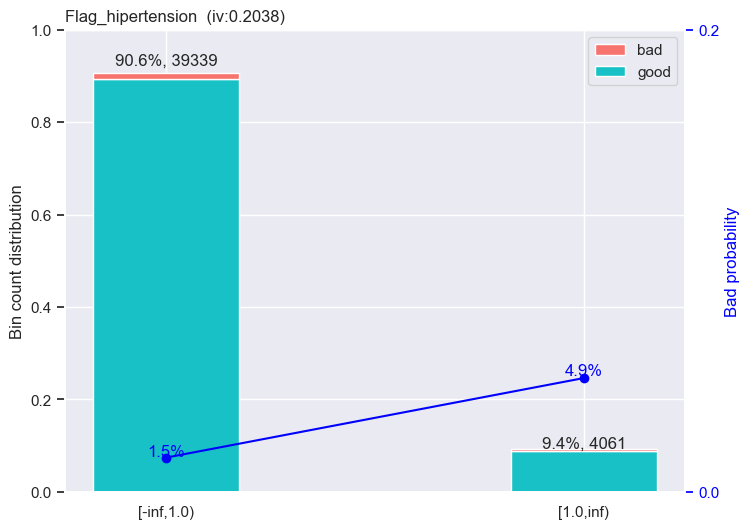

In [1570]:
calcular_iv('Flag_hipertension')

**Hallazgos**
- Se concluye que los clientes que tienen problemas de hipertensión tienen una mayor propensión a tener ataques cardiacos.
- El **Information Value** es bastante alto (0.2038), por lo que esta variable tiene un considerable poder predictivo en nuestro análisis

### 3.4. Flag_problem_cardiaco

[INFO] creating woe binning ...
                variable         bin  count  count_distr   good  bad  \
0  Flag_problem_cardiaco  [-inf,1.0)  41338     0.952488  40732  606   
1  Flag_problem_cardiaco   [1.0,inf)   2062     0.047512   1885  177   

    badprob       woe    bin_iv  total_iv breaks  is_special_values  
0  0.014660 -0.211013  0.038367  0.334982    1.0              False  
1  0.085839  1.631342  0.296615  0.334982    inf              False  

IV de la columna Flag_problem_cardiaco: 0.33498169928888033


<Figure size 1600x600 with 0 Axes>

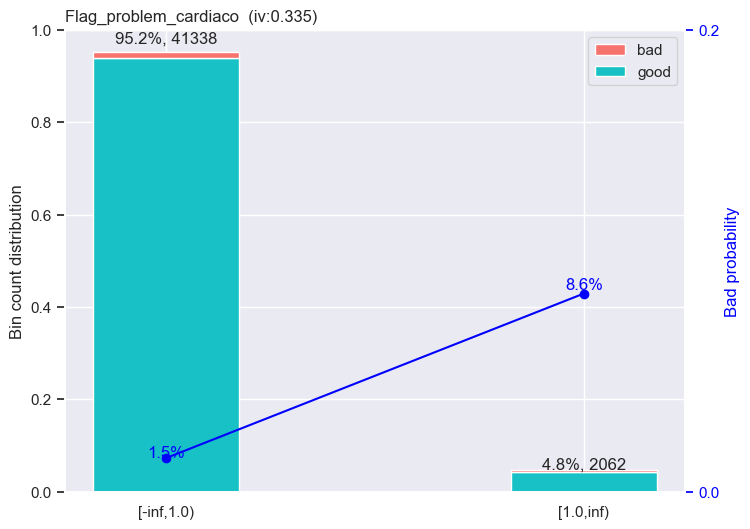

In [1571]:
calcular_iv('Flag_problem_cardiaco',lista_cat=[0,1])

**Hallazgos**
- Similar al caso de Hipertensión: Es mucho más probable que los clientes que tienen problemas cardiacos tengan una mayor propensión a tener ataques cardiacos.
- El **Information Value** es bastante alto (0.335), por lo que esta variable tiene un considerable poder predictivo en nuestro análisis
- Es muy probable que esté correlacionada con Hipertensión. En el análisis multivariado evaluaremos posible multicolinealidad.

### 3.5. Estados_civil

[INFO] creating woe binning ...
        variable bin  count  count_distr   good  bad   badprob       woe  \
0  Estados_civil  No  15462     0.356267  15382   80  0.005174 -1.262051   
1  Estados_civil  Si  27938     0.643733  27235  703  0.025163  0.339975   

     bin_iv  total_iv breaks  is_special_values  
0  0.326574  0.414548     No              False  
1  0.087973  0.414548     Si              False  

IV de la columna Estados_civil: 0.41454751085654706


<Figure size 1600x600 with 0 Axes>

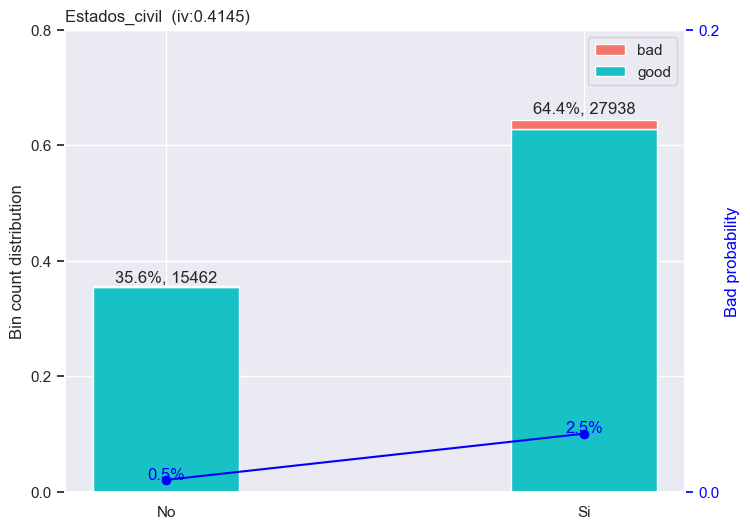

In [1572]:
calcular_iv('Estados_civil')

**Hallazgos**
- Se aprecia que los clientes que están casados tienen una mayor probabilidad de tener ataques cardiacos.
- Esto podría explicarse debido a que a mayor edad, más probabilidad de estar casado. Esto lo podremos corroborar en el análisis multivariado
- El **Information Value** es relevante (0.4145), por lo que esta variable también tiene un considerable poder predictivo en nuestro análisis

### 3.6. Tipo_trabajo

[INFO] creating woe binning ...
       variable                           bin  count  count_distr   good  bad  \
0  Tipo_trabajo  Nunca_trabajo%,%cuidar_ninos   6333     0.145922   6331    2   
1  Tipo_trabajo                   En_gobierno   5440     0.125346   5351   89   
2  Tipo_trabajo               Empresa_privada  24834     0.572212  24393  441   
3  Tipo_trabajo                   Emprendedor   6793     0.156521   6542  251   

    badprob       woe    bin_iv  total_iv                        breaks  \
0  0.000316 -4.063190  0.593232  0.717571  Nunca_trabajo%,%cuidar_ninos   
1  0.016360 -0.099527  0.001184  0.717571                   En_gobierno   
2  0.017758 -0.016131  0.000148  0.717571               Empresa_privada   
3  0.036950  0.736331  0.123008  0.717571                   Emprendedor   

   is_special_values  
0              False  
1              False  
2              False  
3              False  

IV de la columna Tipo_trabajo: 0.7175711343376249


<Figure size 1600x600 with 0 Axes>

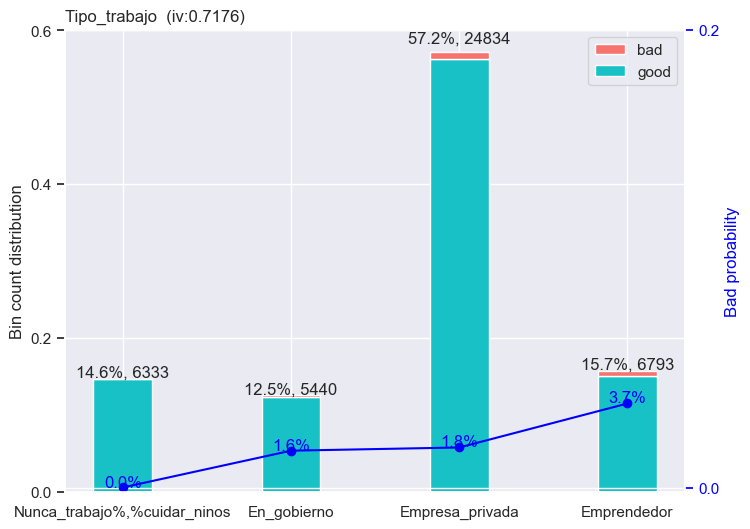

In [1573]:
calcular_iv('Tipo_trabajo')

**Hallazgos**
- Podemos apreciar que los emprendedores tienen una mayor probabilidad de tener problemas cardiacos.
- La probabilidad de las personas que trabajan **en gobierno** y en **empresa_privada** es muy similar, por lo que podríamos considerar agruparlos en el análisis.
- Los clientes que pertenecen a la categoría **nunca_trabajo** y **cuidar_ninos** tiene una probabilidad muy baja (casi nula) de sufrir ataques cardiacos. Queda evaluar si esto está relacionado con la edad.
- El **Information Value** es relevante (0.7176), por lo que esta variable también tiene un considerable poder predictivo en nuestro análisis

### 3.7. Zona_residencia

[INFO] creating woe binning ...
          variable     bin  count  count_distr   good  bad   badprob  \
0  Zona_residencia   Rural  21644      0.49871  21260  384  0.017742   
1  Zona_residencia  Urbano  21756      0.50129  21357  399  0.018340   

        woe    bin_iv  total_iv  breaks  is_special_values  
0 -0.017064  0.000144  0.000285   Rural              False  
1  0.016702  0.000141  0.000285  Urbano              False  

IV de la columna Zona_residencia: 0.0002850077018435941


<Figure size 1600x600 with 0 Axes>

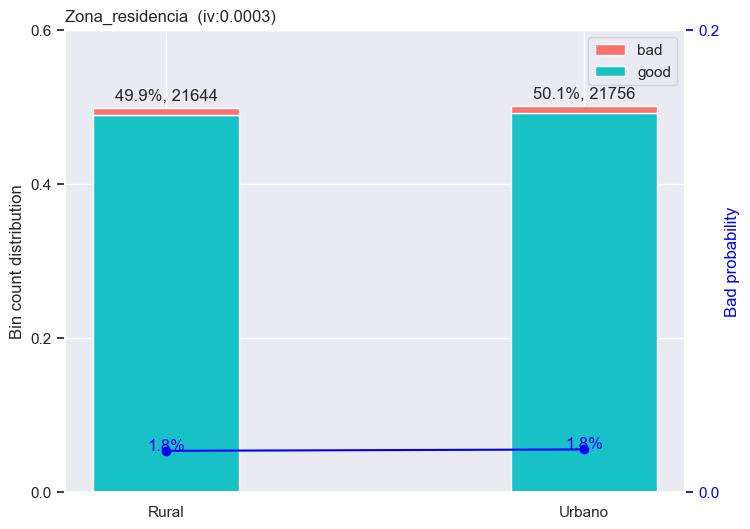

In [1574]:
calcular_iv('Zona_residencia')

**Hallazgos**
- No se ven diferencias significativas entre ambos grupos (Urbano y Rural)
- El **Information Value** es muy bajo (0.0003), por lo que podríamos descartar esta variable para el modelo.

### 3.8. Promedio_nivel_glucosa

[INFO] creating woe binning ...
                 variable            bin  count  count_distr   good  bad  \
0  Promedio_nivel_glucosa   [-inf,125.0)  35528     0.818618  35048  480   
1  Promedio_nivel_glucosa  [125.0,165.0)   2934     0.067604   2884   50   
2  Promedio_nivel_glucosa    [165.0,inf)   4938     0.113779   4685  253   

    badprob       woe    bin_iv  total_iv breaks  is_special_values  
0  0.013510 -0.293812  0.061515  0.291579  125.0              False  
1  0.017042 -0.058035  0.000221  0.291579  165.0              False  
2  0.051235  1.078144  0.229843  0.291579    inf              False  

IV de la columna Promedio_nivel_glucosa: 0.29157885021651586


<Figure size 1600x600 with 0 Axes>

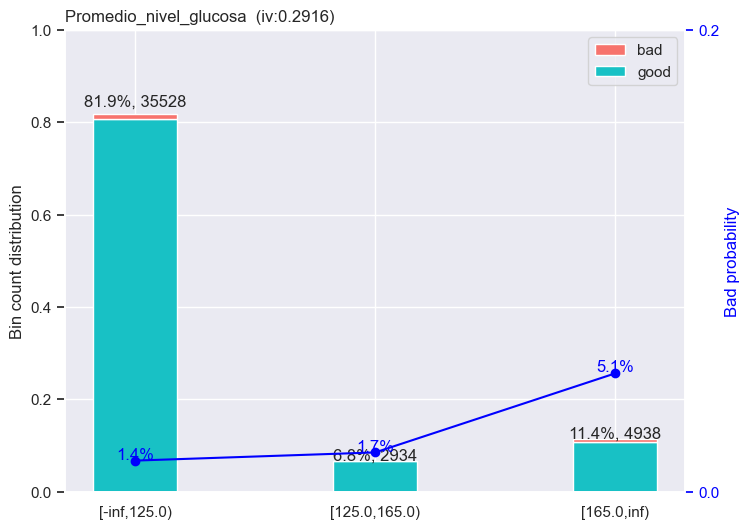

In [1575]:
calcular_iv('Promedio_nivel_glucosa')

**Hallazgos**
- No se ven diferencias significativas entre los primeros grupos (menor a 125 y menos a 165), por lo que podríamos agruparlos en una única categoría.
- Donde se ve una diferencia considerable es con el grupo que presenta un nivel de glucosa superior a 165 unidades.
- El **Information Value** es alto (0.2916), por lo que esta variable estaría considerada en el análisis.

### 3.9. IMC

[INFO] creating woe binning ...
  variable          bin  count  count_distr   good  bad   badprob       woe  \
0      IMC      missing   1462     0.033687   1322  140  0.095759  1.751617   
1      IMC  [-inf,20.0)   4930     0.113594   4917   13  0.002637 -1.938629   
2      IMC  [20.0,25.0)   9299     0.214263   9182  117  0.012582 -0.365951   
3      IMC  [25.0,37.0)  22191     0.511313  21755  436  0.019648  0.086919   
4      IMC   [37.0,inf)   5518     0.127143   5441   77  0.013954 -0.261037   

     bin_iv  total_iv   breaks  is_special_values  
0  0.258852  0.486187  missing               True  
1  0.191485  0.486187     20.0              False  
2  0.024163  0.486187     25.0              False  
3  0.004029  0.486187     37.0              False  
4  0.007657  0.486187      inf              False  

IV de la columna IMC: 0.4861869808842977


<Figure size 1600x600 with 0 Axes>

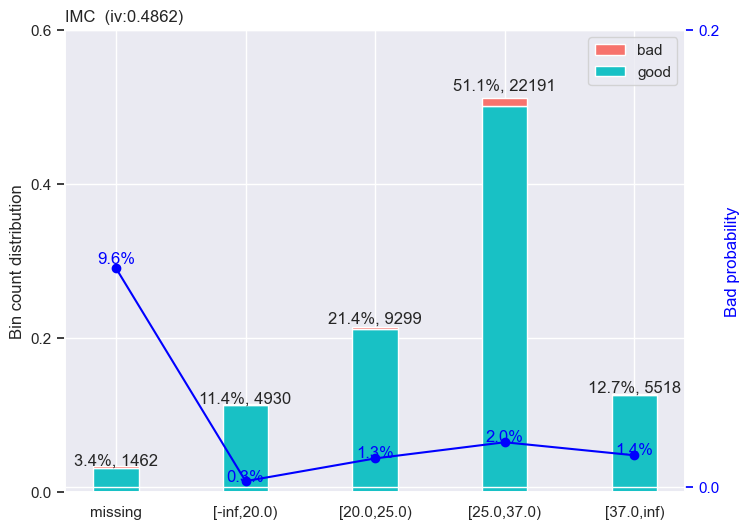

In [1576]:
calcular_iv('IMC')

In [1577]:
# Realizaremos una copia para no considerar los nulos que están distorsionando el análisis
df_imc = df[['IMC','Ataque_cardiaco']].copy()
df_imc = df_imc[df_imc['IMC'].notna()]

Haremos la separación de categorías basados en la tabla de IMC de la OMS

|Categoría|Rango IMC|
|-----|-----|
|Bajo peso|Menos de 18.5|
|Peso saludable|18.5 a 24.9|
|Sobrepeso|25.0 a 29.9|
|Obesidad (general)|30.0 o más|

Para este análisis, solo tomaremos como puntos de corte: 
- 25: El límite entre peso saludable y saludable
- 30: El límite entre sobrepeso y obesidad

In [1578]:
categorias_imc = [25,30]

[INFO] creating woe binning ...
  variable          bin  count  count_distr   good  bad   badprob       woe  \
0      IMC  [-inf,25.0)  14229     0.339287  14099  130  0.009136 -0.523973   
1      IMC  [25.0,30.0)  11694     0.278840  11463  231  0.019754  0.257890   
2      IMC   [30.0,inf)  16015     0.381873  15733  282  0.017608  0.140743   

     bin_iv  total_iv breaks  is_special_values  
0  0.072960  0.102125   25.0              False  
1  0.021061  0.102125   30.0              False  
2  0.008104  0.102125    inf              False  

IV de la columna IMC: 0.10212467422000698


<Figure size 1600x600 with 0 Axes>

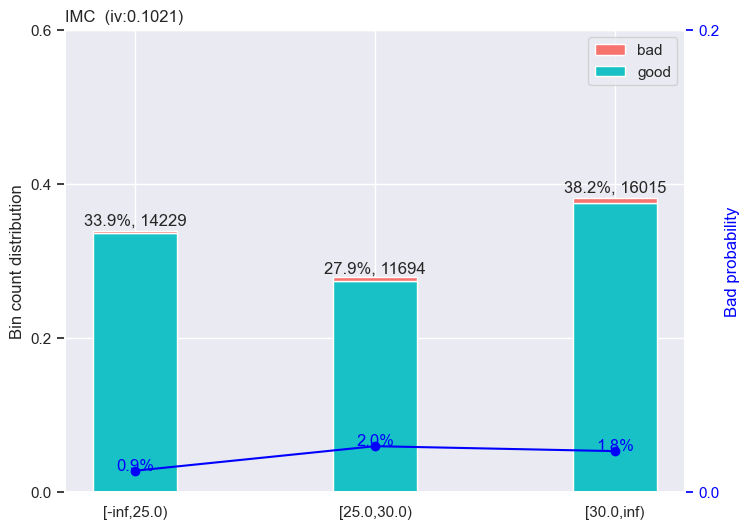

In [1579]:
calcular_iv('IMC',target='Ataque_cardiaco',df=df_imc,lista_cat=categorias_imc)

**Hallazgos**
- No se ven diferencias significativas entre los grupos de sobrepeso y obesidad. 
- Por otro lado, sí se ve una ligera diferencia con el grupo de peso saludable.
- El **Information Value** es relativamente bajo (0.1021), por lo que podríamos optar por no considerarlo
- Asimismo, los valores nulos tienen una alta probabilidad de 

### 3.10. Flag_fumador

[INFO] creating woe binning ...
       variable           bin  count  count_distr   good  bad   badprob  \
0  Flag_fumador       missing  13292     0.306267  13147  145  0.010909   
1  Flag_fumador    Nunca_fuma  16053     0.369885  15769  284  0.017691   
2  Flag_fumador       fumador   6562     0.151198   6429  133  0.020268   
3  Flag_fumador  antes_fumaba   7493     0.172650   7272  221  0.029494   

        woe    bin_iv  total_iv        breaks  is_special_values  
0 -0.510339  0.062928  0.121498       missing               True  
1 -0.019951  0.000146  0.121498    Nunca_fuma              False  
2  0.118651  0.002255  0.121498       fumador              False  
3  0.503252  0.056169  0.121498  antes_fumaba              False  

IV de la columna Flag_fumador: 0.12149772706389245


<Figure size 1600x600 with 0 Axes>

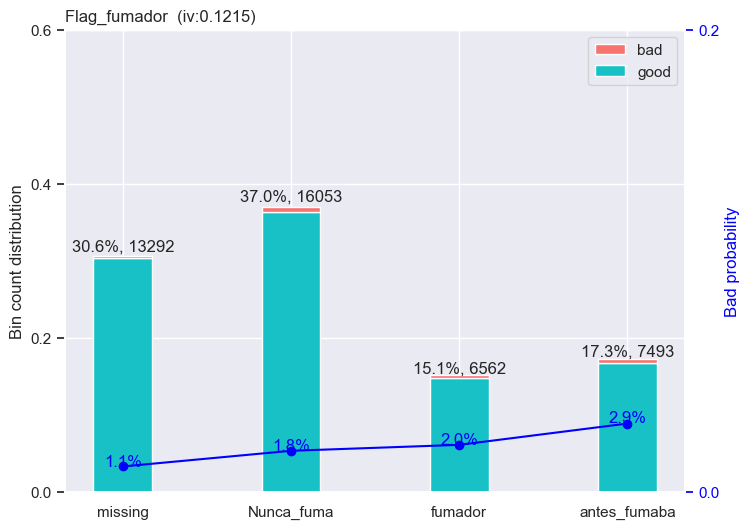

In [1580]:
calcular_iv('Flag_fumador')

**Hallazgos**
- De manera contraintuitiva, las personas que antes fumaban tienen más probabilidad de tener un ataque cardiaco que las personas que siguen fumando.
- Las personas que no fuman tienen la menor probabilidad de sufrir un ataque, incluso menos que los que declaran que nunca fuman.
- El grupo con menor probabilidad de sufrir un ataque cardiaco con los clientes que no tienen dato.
- Las diferencias en cuanto a la probabilidad de tener un ataque cardiaco respecto al grupo que nunca fuman son bastante bajas.
- El **Information Value** de 0.1215 nos indica que podríamos considerarlo. Se tendría que evaluar en el análisis univariado.

### 2.3. Análisis Multivariado

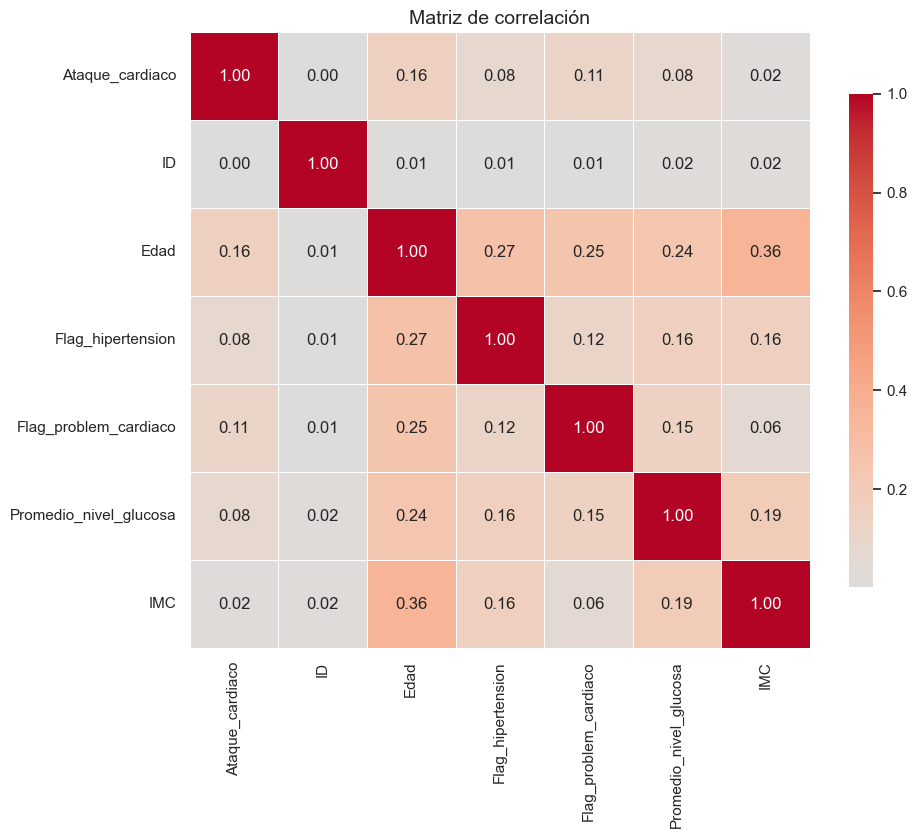

In [1581]:
corr = df[['Ataque_cardiaco'] + [c for c in df.columns if c != 'Ataque_cardiaco']].corr(numeric_only=True)

plt.figure(figsize=(10,8))
sns.heatmap(
    corr,
    annot=True,           
    cmap='coolwarm',     
    center=0,           
    fmt=".2f",          
    linewidths=0.5,      
    cbar_kws={'shrink': 0.8} 
)
plt.title('Matriz de correlación', fontsize=14)
plt.show()

**Hallazgos**
- En el dataset original, podemos detectar que ninguna de las variables presenta una correlación muy significativa con **Ataque_cardiaco**. Esto puede deberse al desbalance muy grande de los datos que pudimos observar en el análisis univariado.
- No obstante, la variable con un mayor nivel de correlación es el de la **Edad**. De acuerdo a lo visto en el análisis bivariado, la probabilidad aumenta considerablemente a partir de los 65 años en adelante.
- Es posible asumir que a medida que uno va adquiriendo mayor edad, es más propenso a sufrir problemas de salud (en general), por lo que los indicadores de salud empeoran con el tiempo, dentro de los cuales se pueden presentar afecciones cardiacas.
- Por otro lado, la variable **Edad** tiene correlación con los flags de Hipertension, Problema_cardiaco, Nivel de Glucosa y el IMC.
- Las variables de ID e IMC prácticamente no tienen impacto en la variable objetivo, con correlaciones muy cercanas a 0.

## 3. Feature Engineering

### 3.1. Split en Train y Test

In [1582]:
# Generar un dataset de copia
df_transform = df.copy()

# Quitaremos las columnas ID (por ser una columna de identificación)
df_transform.drop(columns=['ID'],inplace=True)

In [1583]:
# Realizamos el train y test split para evitar data leakage
X = df_transform.drop(columns=['Ataque_cardiaco'])
y = df_transform['Ataque_cardiaco']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42,stratify=y)

train = pd.concat([X_train,y_train],axis=1)
test = pd.concat([X_test,y_test],axis=1)

In [1584]:
train.head()

,Genero,Edad,Flag_hipertension,Flag_problem_cardiaco,Estados_civil,Tipo_trabajo,Zona_residencia,Promedio_nivel_glucosa,IMC,Flag_fumador,Ataque_cardiaco
1364,Mujer,17.0,0,0,No,En_gobierno,Rural,115.93,23.3,Nunca_fuma,0
31728,Hombre,77.0,1,0,Si,En_gobierno,Rural,117.66,25.7,antes_fumaba,0
29547,Mujer,27.0,0,0,No,Empresa_privada,Rural,135.24,23.8,antes_fumaba,0
9701,Mujer,48.0,0,0,Si,Empresa_privada,Urbano,86.20,37.6,Nunca_fuma,0
18917,Mujer,33.0,0,0,Si,Empresa_privada,Urbano,96.87,33.9,antes_fumaba,0


In [1585]:
test.head()

,Genero,Edad,Flag_hipertension,Flag_problem_cardiaco,Estados_civil,Tipo_trabajo,Zona_residencia,Promedio_nivel_glucosa,IMC,Flag_fumador,Ataque_cardiaco
14530,Mujer,41.0,0,0,Si,Empresa_privada,Rural,64.88,22.5,Nunca_fuma,0
38565,Mujer,20.0,0,0,No,Emprendedor,Urbano,61.48,30.8,Nunca_fuma,0
16050,Mujer,68.0,0,1,Si,Empresa_privada,Rural,217.68,28.3,fumador,0
42215,Mujer,16.0,0,0,No,Empresa_privada,Urbano,82.50,26.2,antes_fumaba,0
3109,Hombre,52.0,1,0,Si,En_gobierno,Urbano,214.43,39.9,fumador,0


### 3.2. Imputación de Datos Faltantes

In [1586]:
validar_faltantes(train)

Columnas con datos faltantes: 2


,variable,nulos,%
1,Flag_fumador,10644,0.31
0,IMC,1148,0.03


In [1587]:
validar_faltantes(test)

Columnas con datos faltantes: 2


,variable,nulos,%
1,Flag_fumador,2648,0.31
0,IMC,314,0.04


In [1588]:
mediana_imc = np.median(train['IMC'].dropna())

print('Mediana IMC:',mediana_imc)

Mediana IMC: 27.7


In [1589]:
# Imputar el train y test
train['IMC'].fillna(mediana_imc,inplace=True)
test['IMC'].fillna(mediana_imc,inplace=True)

In [1590]:
# Asignamos una nueva categoría a la categoría Flag Fumador
train['Flag_fumador'] = train['Flag_fumador'].fillna('No se sabe')
test['Flag_fumador'] = test['Flag_fumador'].fillna('No se sabe')

### 3.3. Tratamiento de Outliers

In [1591]:
cols_numericas = train.select_dtypes(include='number').columns 
cols_numericas

Index(['Edad', 'Flag_hipertension', 'Flag_problem_cardiaco',
       'Promedio_nivel_glucosa', 'IMC', 'Ataque_cardiaco'],
      dtype='object')

In [1592]:
def validar_outliers_dataframe(df):

    resultados = []

    # Solo columnas numéricas
    cols_numericas = df.select_dtypes(include='number').columns 
    
    for col in cols_numericas:
        Q1 = df[col].quantile(0.25)
        Q3 = df[col].quantile(0.75)
        IQR = Q3 - Q1

        lower_whisker = Q1 - 1.5 * IQR
        upper_whisker = Q3 + 1.5 * IQR

        outliers = df[(df[col] < lower_whisker) | (df[col] > upper_whisker)]

        if len(outliers) > 0:
            total_outliers = outliers.shape[0]
            total_filas = df[col].shape[0]

            porc_outliers = round((total_outliers / total_filas) * 100, 2)

            resultados.append({
                'columna': col,
                'total_outliers': total_outliers,
                '%_outliers': porc_outliers
            })

    return pd.DataFrame(resultados).sort_values(by='%_outliers',ascending=False)


In [1593]:
def tratar_outliers(col: str, df: pd.DataFrame, perc: tuple | None = None):

    """
    Función para tratar los outliers de una variable numérica.
    Args:
    - col: la columna que se va a tratar
    - df: el Dataframe que contiene la columna que se va a tratar
    - perc -> tupla (opcional): los percentiles que se usarán para clipear. Es necesario pasar los percentiles superior e inferior (en orden)
    En caso de que sea None, se tomará el valor del lower y upper whisker para reemplazar los outliers.
    """

    Q1 = df[col].quantile(0.25)
    Q3 = df[col].quantile(0.75)
    
    IQR = Q3 - Q1

    lower_whisker = Q1 - 1.5 * IQR
    upper_whisker = Q3 + 1.5 * IQR

    if perc:

        lim_inf = df[col].quantile(perc[0])
        lim_sup = df[col].quantile(perc[1])

        # Convertir los valores 
        df[col] = np.where(df[col] < lim_inf, lim_inf, df[col])
        df[col] = np.where(df[col] > lim_sup, lim_sup, df[col])

    else:
        # Convertir los valores 
        df[col] = np.where(df[col] < lower_whisker, lower_whisker, df[col])
        df[col] = np.where(df[col] > upper_whisker, upper_whisker, df[col])

    return df[col]

In [1594]:
validar_outliers_dataframe(train[['Edad','Promedio_nivel_glucosa','IMC']])

,columna,total_outliers,%_outliers
0,Promedio_nivel_glucosa,3966,11.42
1,IMC,860,2.48


count    34720.000000
mean       104.295582
std         42.912906
min         55.000000
25%         77.490000
50%         91.500000
75%        111.800000
max        291.050000
Name: Promedio_nivel_glucosa, dtype: float64


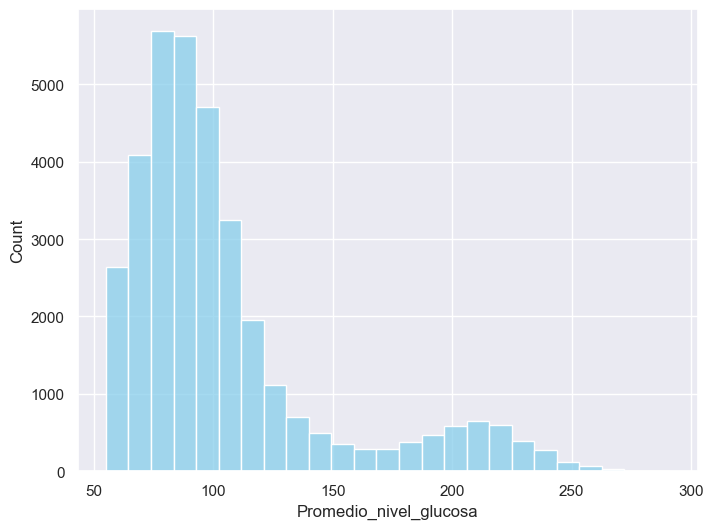

In [1595]:
grafico_histograma('Promedio_nivel_glucosa',train)

In [1596]:
train['Promedio_nivel_glucosa'] = tratar_outliers('Promedio_nivel_glucosa',train,perc=(0.05,0.95))
train['IMC'] = tratar_outliers('IMC',train,perc=(0.05,0.95))

count    34720.000000
mean       103.616438
std         40.318406
min         61.270000
25%         77.490000
50%         91.500000
75%        111.800000
max        211.720000
Name: Promedio_nivel_glucosa, dtype: float64


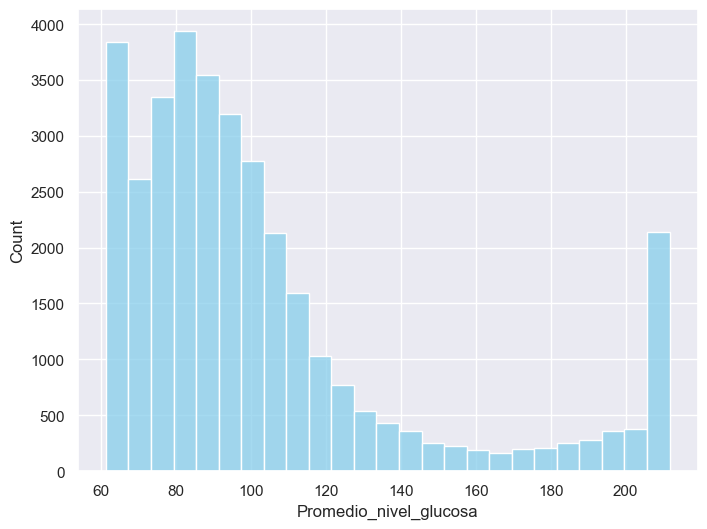

In [1597]:
grafico_histograma('Promedio_nivel_glucosa',train)

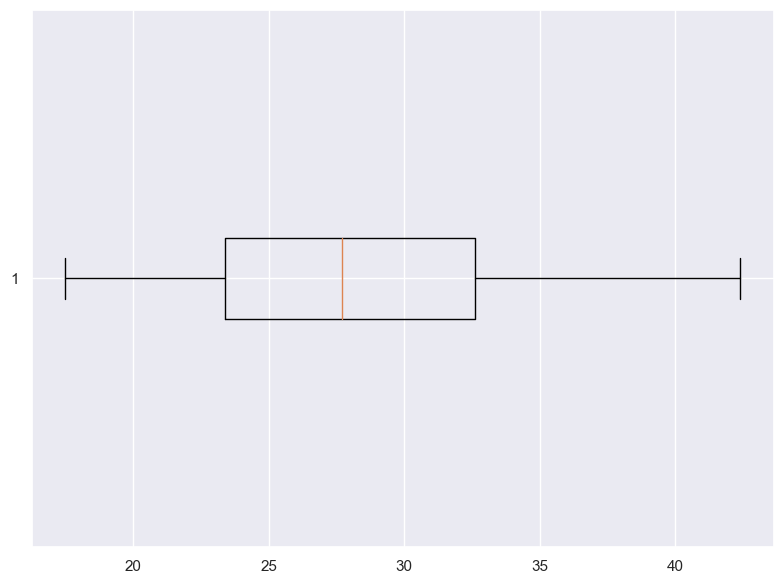

In [1598]:
plt.boxplot(train['IMC'],vert=False)
plt.tight_layout()
plt.show()

### 3.4. Creación de nuevas variables

In [1599]:
# Crearemos variables logarítmicas de la edad e IMC, para comparar si es mejor tener la variable logarítmica o normal
train['Edad_log'] = np.log1p(train['Edad'])
test['Edad_log'] = np.log1p(test['Edad'])

# Raiz Cuadrada
train['Edad_sqrt'] = np.sqrt(train['Edad'])
test['Edad_sqrt'] = np.sqrt(test['Edad'])

count    34720.000000
mean         3.529343
std          0.843041
min          0.076961
25%          3.218876
50%          3.806662
75%          4.110874
max          4.418841
Name: Edad_log, dtype: float64


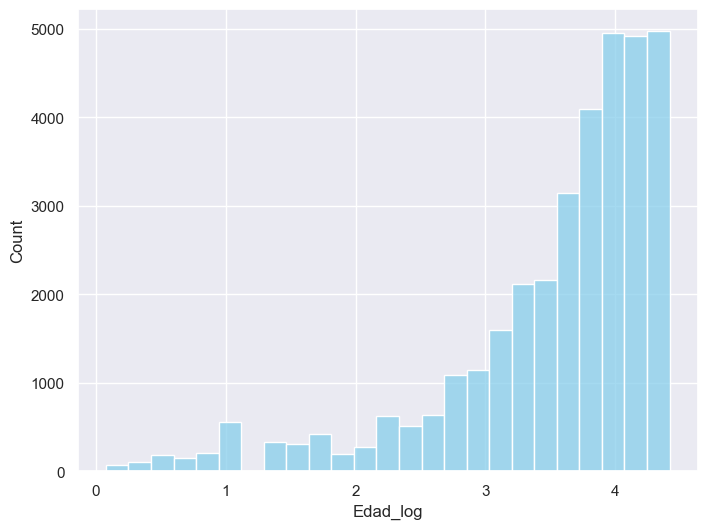

In [1600]:
grafico_histograma('Edad_log',train)

count    34720.000000
mean         6.173194
std          2.037556
min          0.282843
25%          4.898979
50%          6.633250
75%          7.745967
max          9.055385
Name: Edad_sqrt, dtype: float64


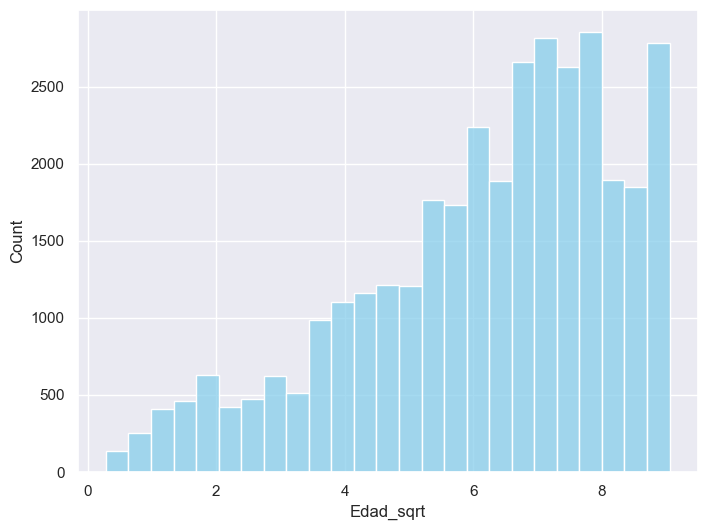

In [1601]:
grafico_histograma('Edad_sqrt',train)

**Hallazgos**
- Las distribuciones de las edades, ya sean logarítmicas o de raiz cuadrada, generan un sesgo importante a la izquierda.
- Se tiene que evaluar si esto mejora el rendimiento de la variable Edad sin transformación

In [1602]:
# Crearemos variables logarítmicas de la edad e IMC, para comparar si es mejor tener la variable logarítmica o normal
train['IMC_log'] = np.log1p(train['IMC'])
test['IMC_log'] = np.log1p(test['IMC'])

# Raiz Cuadrada
train['IMC_sqrt'] = np.sqrt(train['IMC'])
test['IMC_sqrt'] = np.sqrt(test['IMC'])

count    34720.000000
mean         3.354010
std          0.230045
min          2.917771
25%          3.194583
50%          3.356897
75%          3.514526
max          3.770459
Name: IMC_log, dtype: float64


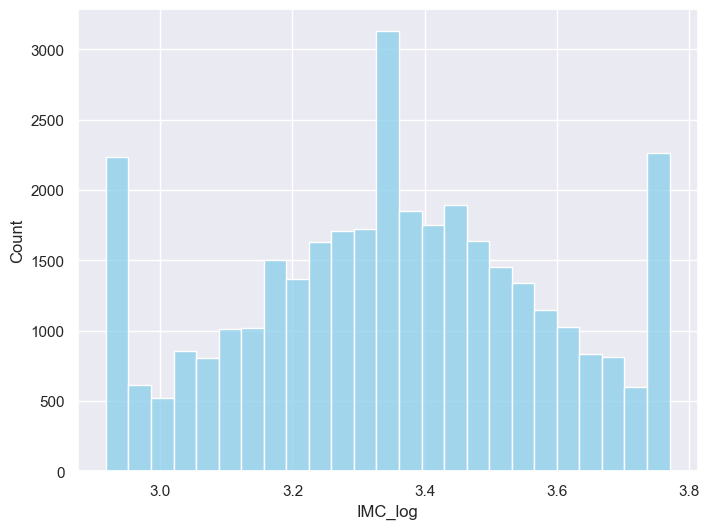

In [1603]:
grafico_histograma('IMC_log',train)

count    34720.000000
mean         5.289909
std          0.628139
min          4.183300
25%          4.837355
50%          5.263079
75%          5.709641
max          6.511528
Name: IMC_sqrt, dtype: float64


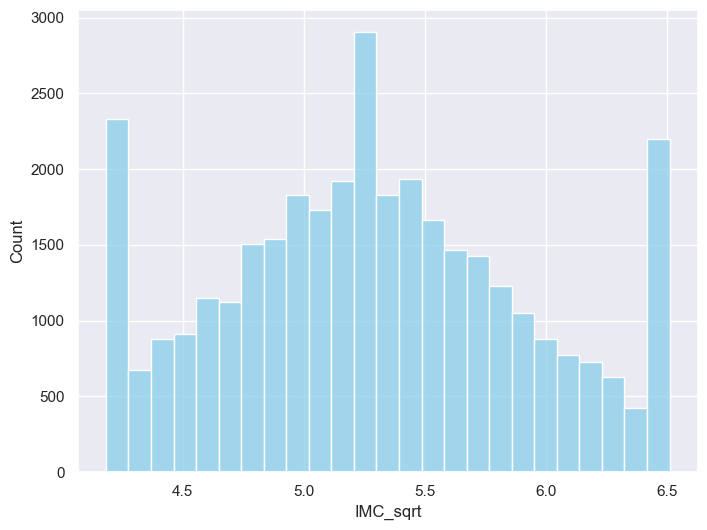

In [1604]:
grafico_histograma('IMC_sqrt',train)

**Hallazgos**
- Se puede apreciar que la transformación de raiz cuadrada normaliza la distribución más que la transformación logarítmica.

In [1605]:
# Crearemos variables logarítmicas de la edad e IMC, para comparar si es mejor tener la variable logarítmica o normal
train['Promedio_nivel_glucosa_log'] = np.log1p(train['Promedio_nivel_glucosa'])
test['Promedio_nivel_glucosa_log'] = np.log1p(test['Promedio_nivel_glucosa'])

# Raiz Cuadrada
train['Promedio_nivel_glucosa_sqrt'] = np.sqrt(train['Promedio_nivel_glucosa'])
test['Promedio_nivel_glucosa_sqrt'] = np.sqrt(test['Promedio_nivel_glucosa'])

count    43400.000000
mean       104.482750
std         43.111751
min         55.000000
25%         77.540000
50%         91.580000
75%        112.070000
max        291.050000
Name: Promedio_nivel_glucosa, dtype: float64


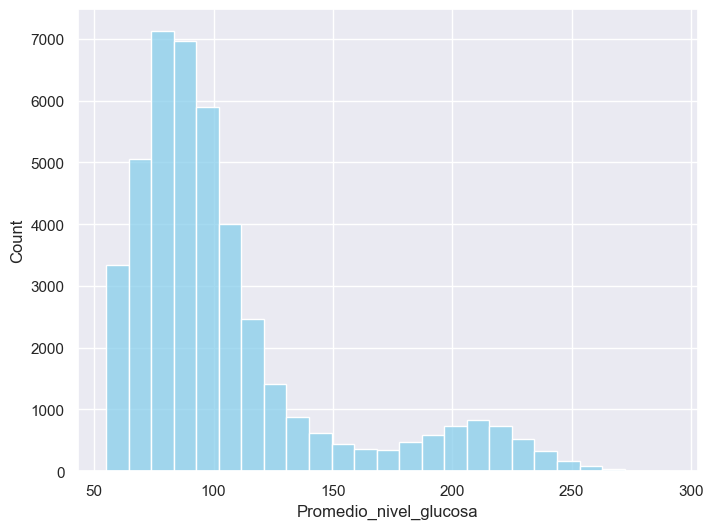

In [1606]:
grafico_histograma('Promedio_nivel_glucosa',df)

count    34720.000000
mean       103.616438
std         40.318406
min         61.270000
25%         77.490000
50%         91.500000
75%        111.800000
max        211.720000
Name: Promedio_nivel_glucosa, dtype: float64


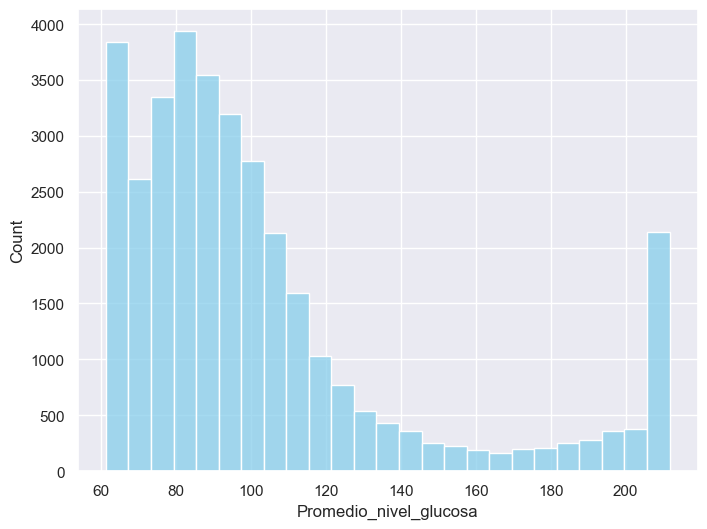

In [1607]:
grafico_histograma('Promedio_nivel_glucosa',train)

count    34720.000000
mean         4.590385
std          0.330105
min          4.131480
25%          4.362971
50%          4.527209
75%          4.725616
max          5.359977
Name: Promedio_nivel_glucosa_log, dtype: float64


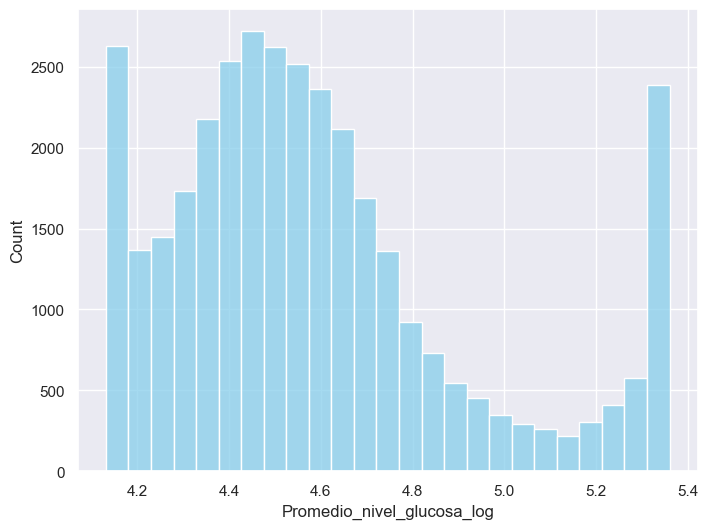

In [1608]:
grafico_histograma('Promedio_nivel_glucosa_log',train)

count    34720.000000
mean        10.018219
std          1.803282
min          7.827516
25%          8.802840
50%          9.565563
75%         10.573552
max         14.550601
Name: Promedio_nivel_glucosa_sqrt, dtype: float64


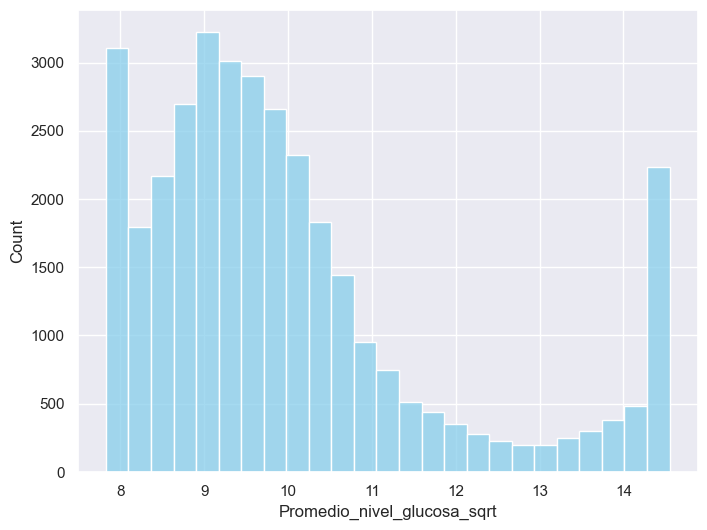

In [1609]:
grafico_histograma('Promedio_nivel_glucosa_sqrt',train)

**Hallazgos**
- Ambas transformaciones presentan una distribución muy similar. Se puede ver una distribución marcadamente bimodal, con la presencia de valores muy altos pasada la cola.

In [1610]:
# Convertimos la variable Estado Civil a categorías numéricas
train['Estados_civil_cat'] = np.where(train['Estados_civil']=='Si',1,0)
test['Estados_civil_cat'] = np.where(test['Estados_civil']=='Si',1,0)

In [1611]:
# Convertimos la variable Zona_Residencia a categorías numéricas
train['Zona_residencia_Urbano'] = np.where(train['Zona_residencia']=='Urbano',1,0)
train['Zona_residencia_Rural'] = np.where(train['Zona_residencia']=='Rural',1,0)

test['Zona_residencia_Urbano'] = np.where(test['Zona_residencia']=='Urbano',1,0)
test['Zona_residencia_Rural'] = np.where(test['Zona_residencia']=='Rural',1,0)

In [1612]:
# Convertimos la variable Zona_Residencia a categorías numéricas
train['Flag_Fumador_Nunca_fuma'] = np.where(train['Flag_fumador']=='Nunca_fuma',1,0)
train['Flag_Fumador_Antes_fumaba'] = np.where(train['Flag_fumador']=='antes_fumaba',1,0)
train['Flag_Fumador_Fumador'] = np.where(train['Flag_fumador']=='fumador',1,0)
train['Flag_Fumador_No_se_sabe'] = np.where(train['Flag_fumador']=='No se sabe',1,0)

test['Flag_Fumador_Nunca_fuma'] = np.where(test['Flag_fumador']=='Nunca_fuma',1,0)
test['Flag_Fumador_Antes_fumaba'] = np.where(test['Flag_fumador']=='antes_fumaba',1,0)
test['Flag_Fumador_Fumador'] = np.where(test['Flag_fumador']=='fumador',1,0)
test['Flag_Fumador_No_se_sabe'] = np.where(test['Flag_fumador']=='No se sabe',1,0)

In [1613]:
# Convertimos la variable Genero a números
# De acuerdo a lo analizado en el Bivariado, agruparemos Other con la categoría mujer por ser la categoría con menor probabilidad
train['Genero_M'] = np.where(train['Genero']=='Hombre',1,0)
train['Genero_F'] = np.where(train['Genero']!='Hombre',1,0)

test['Genero_M'] = np.where(test['Genero']=='Hombre',1,0)
test['Genero_F'] = np.where(test['Genero']!='Hombre',1,0)

In [1614]:
# Agrupamos por nivel de riesgo, según lo observado en el análisis bivariado
dict_tipo_trabajo = {
    'cuidar_ninos': 1,
    'Nunca_trabajo': 1,
    'Empresa_privada': 2,
    'En_gobierno': 2,
    'Emprendedor': 3 
}

# Convertimos la variable Estado Civil a categorías numéricas
train['Tipo_trabajo_cat'] = train['Tipo_trabajo'].replace(dict_tipo_trabajo)
test['Tipo_trabajo_cat'] = test['Tipo_trabajo'].replace(dict_tipo_trabajo)

In [1615]:
def categorizar_edad(edad: float):

    if edad < 35:
        return 1
    elif edad < 50:
        return 2
    elif edad < 66:
        return 3
    else:
        return 4
    
# Convertimos la variable Edad a categorías
train['Edad_cat'] = train['Edad'].apply(categorizar_edad)
test['Edad_cat'] = test['Edad'].apply(categorizar_edad)

In [1616]:
def categorizar_imc(imc: float):

    if imc < 25:
        return 1
    elif imc < 30:
        return 2
    else:
        return 4
    
# Convertimos la variable Edad a categorías
train['IMC_cat'] = train['IMC'].apply(categorizar_imc)
test['IMC_cat'] = test['IMC'].apply(categorizar_imc)

In [1617]:
# Convertimos la variable Nivel Glucosa a categorías
# Según lo visto en el análisis bivariado, hay diferencias significativas cuando supera las 165 unidades
train['Promedio_nivel_glucosa_cat'] = np.where(train['Promedio_nivel_glucosa']<165,0,1)
test['Promedio_nivel_glucosa_cat'] = np.where(test['Promedio_nivel_glucosa']<165,0,1)

In [1618]:
train.head()

,Genero,Edad,Flag_hipertension,Flag_problem_cardiaco,Estados_civil,Tipo_trabajo,Zona_residencia,Promedio_nivel_glucosa,IMC,Flag_fumador,...,Flag_Fumador_Nunca_fuma,Flag_Fumador_Antes_fumaba,Flag_Fumador_Fumador,Flag_Fumador_No_se_sabe,Genero_M,Genero_F,Tipo_trabajo_cat,Edad_cat,IMC_cat,Promedio_nivel_glucosa_cat
1364,Mujer,17.0,0,0,No,En_gobierno,Rural,115.93,23.3,Nunca_fuma,...,1,0,0,0,0,1,2,1,1,0
31728,Hombre,77.0,1,0,Si,En_gobierno,Rural,117.66,25.7,antes_fumaba,...,0,1,0,0,1,0,2,4,2,0
29547,Mujer,27.0,0,0,No,Empresa_privada,Rural,135.24,23.8,antes_fumaba,...,0,1,0,0,0,1,2,1,1,0
9701,Mujer,48.0,0,0,Si,Empresa_privada,Urbano,86.20,37.6,Nunca_fuma,...,1,0,0,0,0,1,2,2,4,0
18917,Mujer,33.0,0,0,Si,Empresa_privada,Urbano,96.87,33.9,antes_fumaba,...,0,1,0,0,0,1,2,1,4,0


In [1619]:
validar_faltantes(train)

Columnas con datos faltantes: 0


,variable,nulos,%


### 3.1. Escalamiento de Datos

In [1620]:
scaler = StandardScaler()

# Seleccionamos las columnas que vamos a escalar (variables numéricas no categóricas ordinales)
cols_a_escalar = ['Edad','Promedio_nivel_glucosa','IMC']

# Escalar el X_train
X_train_scaled = scaler.fit_transform(train[cols_a_escalar])
X_test_scaled = scaler.transform(test[cols_a_escalar]) # Transformar el test

In [1621]:
validar_faltantes(train)

Columnas con datos faltantes: 0


,variable,nulos,%


In [1622]:
pd.DataFrame(X_train_scaled,columns=[c + '_scaled' for c in cols_a_escalar])

,Edad_scaled,Promedio_nivel_glucosa_scaled,IMC_scaled
0,-1.122223,0.305412,-0.756033
1,1.543406,0.348321,-0.398689
2,-0.677952,0.784357,-0.681586
3,0.255019,-0.431979,1.373142
4,-0.411389,-0.167331,0.822236
...,...,...,...
34715,1.765542,-0.854124,-0.592250
34716,-1.033369,-0.581540,-0.473136
34717,-1.388786,0.105501,-1.053820
34718,-0.988942,-0.585261,0.092659


In [1623]:
# Concatenar columnas escaladas con los datasets de prueba
train = pd.concat([train.reset_index(drop=True),pd.DataFrame(X_train_scaled,columns=[c + '_scaled' for c in cols_a_escalar])],axis=1)
test = pd.concat([test.reset_index(drop=True),pd.DataFrame(X_test_scaled,columns=[c + '_scaled' for c in cols_a_escalar])],axis=1)

In [1624]:
validar_faltantes(train)

Columnas con datos faltantes:

 0


,variable,nulos,%


In [1625]:
train.head()

,Genero,Edad,Flag_hipertension,Flag_problem_cardiaco,Estados_civil,Tipo_trabajo,Zona_residencia,Promedio_nivel_glucosa,IMC,Flag_fumador,...,Flag_Fumador_No_se_sabe,Genero_M,Genero_F,Tipo_trabajo_cat,Edad_cat,IMC_cat,Promedio_nivel_glucosa_cat,Edad_scaled,Promedio_nivel_glucosa_scaled,IMC_scaled
0,Mujer,17.0,0,0,No,En_gobierno,Rural,115.93,23.3,Nunca_fuma,...,0,0,1,2,1,1,0,-1.122223,0.305412,-0.756033
1,Hombre,77.0,1,0,Si,En_gobierno,Rural,117.66,25.7,antes_fumaba,...,0,1,0,2,4,2,0,1.543406,0.348321,-0.398689
2,Mujer,27.0,0,0,No,Empresa_privada,Rural,135.24,23.8,antes_fumaba,...,0,0,1,2,1,1,0,-0.677952,0.784357,-0.681586
3,Mujer,48.0,0,0,Si,Empresa_privada,Urbano,86.20,37.6,Nunca_fuma,...,0,0,1,2,2,4,0,0.255019,-0.431979,1.373142
4,Mujer,33.0,0,0,Si,Empresa_privada,Urbano,96.87,33.9,antes_fumaba,...,0,0,1,2,1,4,0,-0.411389,-0.167331,0.822236


In [1660]:
def calcular_v_cramer(serie1, serie2):
    """Calcula la V de Cramer entre dos variables categóricas."""
    # Eliminar NaN
    serie1 = serie1.dropna()
    serie2 = serie2.dropna()

    # Crear tabla de contingencia
    tabla = pd.crosstab(serie1, serie2)

    # Si la tabla está vacía o tiene una sola fila/columna, retornar NaN
    if tabla.size == 0 or tabla.shape[0] < 2 or tabla.shape[1] < 2:
        return np.nan

    # Calcular estadístico chi2
    chi2 = chi2_contingency(tabla, correction=False)[0]
    n = tabla.sum().sum()
    r, k = tabla.shape
    return np.sqrt(chi2 / (n * (min(k - 1, r - 1))))

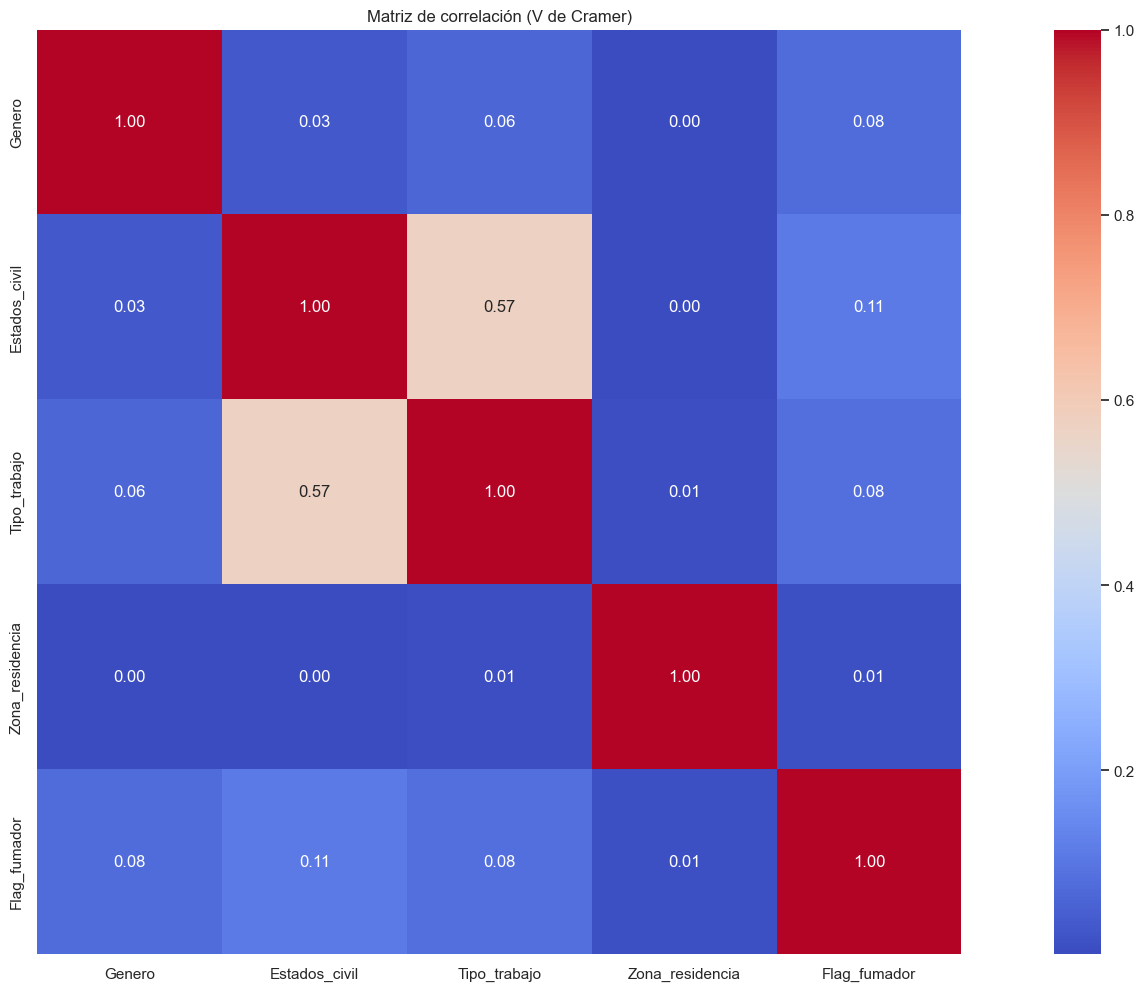

In [1662]:
cols_categoricas = df.select_dtypes(include="object").columns

# Creamos una matriz vacía
cramer_matrix = pd.DataFrame(index=cols_categoricas, columns=cols_categoricas)

# Calculamos la V de Cramer para cada par de variables categóricas
for col1 in cols_categoricas:
    for col2 in cols_categoricas:
        if col1 == col2:
            cramer_matrix.loc[col1, col2] = 1.0  # Correlación perfecta consigo misma
        else:
            cramer_matrix.loc[col1, col2] = calcular_v_cramer(df[col1], df[col2])

# Convertimos todo a tipo flotante para la visualización
cramer_matrix = cramer_matrix.astype(float)

# Graficamos la matriz de V de Cramer
plt.figure(figsize=(24, 12))
sns.heatmap(cramer_matrix, annot=True, cmap='coolwarm', fmt=".2f", square=True)
plt.title("Matriz de correlación (V de Cramer)")
plt.show()

[INFO] creating woe binning ...
       variable              bin  count  count_distr  good    bad   badprob  \
0  Tipo_trabajo      En_gobierno   4359     0.125547   793   3566  0.818078   
1  Tipo_trabajo  Empresa_privada  19867     0.572206  5751  14116  0.710525   
2  Tipo_trabajo      Emprendedor   5453     0.157056   728   4725  0.866496   
3  Tipo_trabajo     cuidar_ninos   4893     0.140927  4893      0  0.000000   
4  Tipo_trabajo    Nunca_trabajo    148     0.004263   141      7  0.047297   

        woe    bin_iv  total_iv           breaks  is_special_values  
0  0.903738  0.085539  4.024701      En_gobierno              False  
1  0.298296  0.048451  4.024701  Empresa_privada              False  
2  1.270683  0.192685  4.024701      Emprendedor              False  
3 -9.200560  3.657874  4.024701     cuidar_ninos              False  
4 -3.602489  0.040152  4.024701    Nunca_trabajo              False  

IV de la columna Tipo_trabajo: 4.024701252144756


<Figure size 1600x600 with 0 Axes>

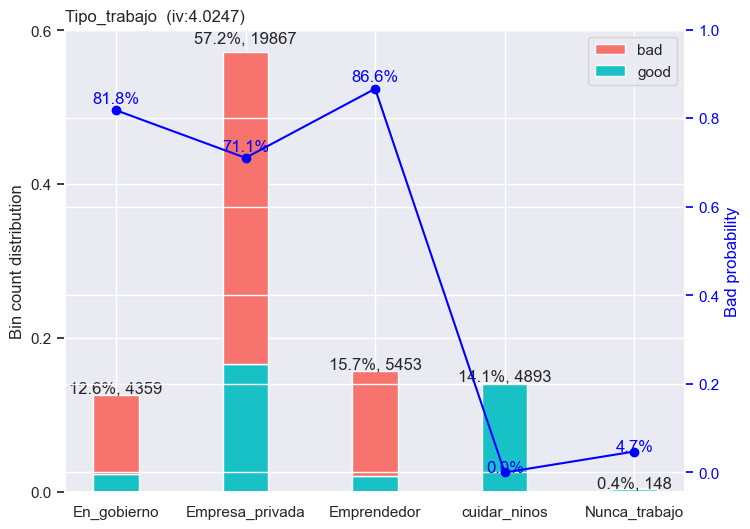

In [1664]:
train['Estados_civil_cat'] = np.where(train['Estados_civil']=='Si',1,0)

calcular_iv('Tipo_trabajo',target='Estados_civil_cat',df=train,lista_cat=list(train['Tipo_trabajo'].unique()))

train.drop(columns=['Estados_civil_cat'], inplace=True)

[INFO] creating woe binning ...
  variable          bin  count  count_distr  good    bad   badprob       woe  \
0     Edad  [-inf,18.0)   6003     0.172897  6002      1  0.000167 -9.299447   
1     Edad  [18.0,24.0)   2374     0.068376  2137    237  0.099832 -2.798697   
2     Edad  [24.0,32.0)   3457     0.099568  1785   1672  0.483656 -0.664997   
3     Edad   [32.0,inf)  22886     0.659159  2382  20504  0.895919  1.553081   

     bin_iv  total_iv breaks  is_special_values  
0  4.535200  6.158583   18.0              False  
1  0.456415  6.158583   24.0              False  
2  0.046852  6.158583   32.0              False  
3  1.120115  6.158583    inf              False  

IV de la columna Edad: 6.158582782729626


<Figure size 1600x600 with 0 Axes>

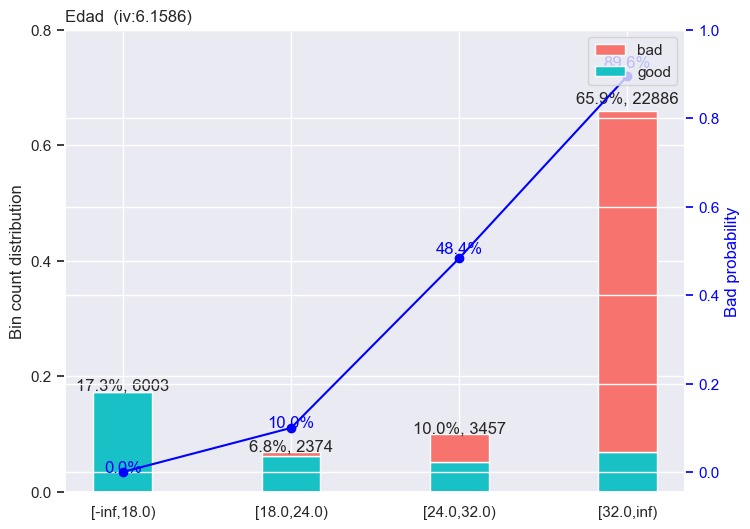

In [1665]:
train['Estados_civil_cat'] = np.where(train['Estados_civil']=='Si',1,0)

calcular_iv('Edad',target='Estados_civil_cat',df=train)

train.drop(columns=['Estados_civil_cat'], inplace=True)

**Hallazgos**
- En la matriz de correlación para variables categóricas podemos apreciar que la única correlación significativa es la que hay entre el Tipo de Trabajo y Estado Civil.
- Revisando la gráfica del Estado Civil por Tipo de Trabjo, podemos apreciar lo siguiente:
  - Las personas que cuidan niños y no trabajan no suelen estar casadas.
  - La probabilidad se dispara cuando son trabajadores de oficina (privada o gubernamental), aún más cuando son emprendedoras.
  - Contrastando con la gráfica de **Edad por Estado Civil**, podemos ver que a partir de los 32 años, la probabilidad de ya estar casado, o en pareja, se eleva hasta un 89.6%
  - Esto podría explicarse debido a que: A mayor edad, uno ya busca cierta estabilidad como meta de vida, tanto en el aspecto emocional como laboral.

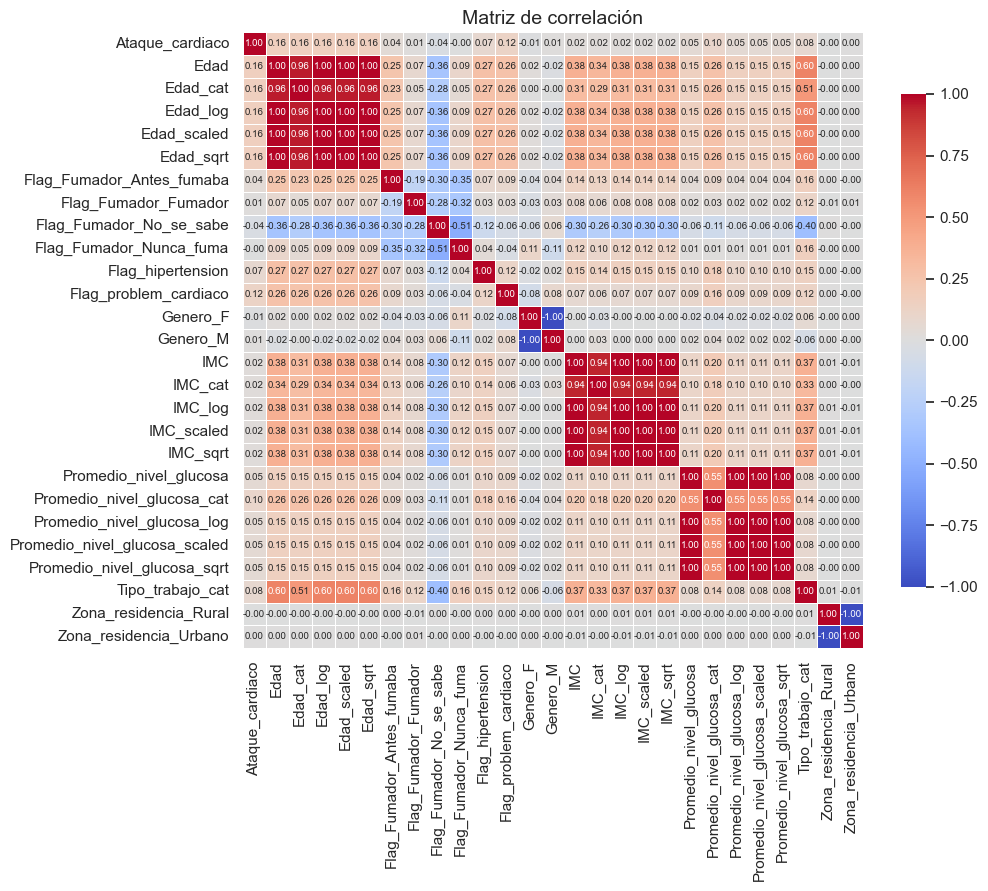

In [1666]:
corr = train[['Ataque_cardiaco'] + [c for c in sorted(train.columns) if c != 'Ataque_cardiaco']].corr(numeric_only=True,method='spearman')

plt.figure(figsize=(10,8))
sns.heatmap(
    corr,
    annot=True,           
    cmap='coolwarm',     
    center=0,           
    fmt=".2f",          
    linewidths=0.5,      
    cbar_kws={'shrink': 0.8},
    annot_kws={"size": 7},     
    xticklabels=True,
    yticklabels=True
)
plt.title('Matriz de correlación', fontsize=14)
plt.show()

**Hallazgos**
- El impacto de las correlaciones es muy bajo porque se está trabajando con la variable objetivo desbalanceada. Se sugiere revisar estas mismas correlaciones con la variable ya balanceada.
- Las variables de Edad no aumentan el nivel de correlación con la variable objetivo, a pesar de las distintas transformaciones.
- Podemor ver que las variables de **Género**, de **IMC** y de **Zona Residencial** tienen un impacto muy bajo con respecto a la probabilidad de **Ataques cardiacos**
- La correlación de **nivel de glucosa** se duplica cuando se la categoría en **menor a 165** o **mayor a 165**

## Balanceo de Datos

In [1627]:
# Dividir por clase('
df_class_0 = train[train['Ataque_cardiaco'] == 0]
df_class_1 = train[train['Ataque_cardiaco'] == 1]

count_class_0 = len(df_class_0)
count_class_1 = len(df_class_1)

print('Ataque Cardiaco')
print('  Clase 0:',count_class_0)
print('  Clase 1:',count_class_1)

Ataque Cardiaco
  Clase 0: 34094
  Clase 1: 626


In [1628]:
#Ejemplo
df_class_0.sample(3)

,Genero,Edad,Flag_hipertension,Flag_problem_cardiaco,Estados_civil,Tipo_trabajo,Zona_residencia,Promedio_nivel_glucosa,IMC,Flag_fumador,...,Flag_Fumador_No_se_sabe,Genero_M,Genero_F,Tipo_trabajo_cat,Edad_cat,IMC_cat,Promedio_nivel_glucosa_cat,Edad_scaled,Promedio_nivel_glucosa_scaled,IMC_scaled
1082,Mujer,48.0,0,0,Si,Empresa_privada,Rural,111.64,36.5,antes_fumaba,...,0,0,1,2,2,4,0,0.255019,0.199008,1.209359
1614,Mujer,78.0,1,0,Si,Empresa_privada,Rural,211.72,38.8,Nunca_fuma,...,0,0,1,2,4,4,1,1.587834,2.681285,1.551814
24799,Hombre,57.0,1,0,No,Empresa_privada,Rural,207.14,39.8,No se sabe,...,1,1,0,2,3,4,1,0.654863,2.567687,1.700707


### 3. Undersampling

In [1629]:
df_class_0_under = df_class_0.sample(count_class_1,random_state=1206)

print('Total Filas')
print('  Clase 0 - Undersampling:',df_class_0_under.shape[0])
print('  Clase 1 - Normal:',df_class_1.shape[0])

Total Filas
  Clase 0 - Undersampling: 626
  Clase 1 - Normal: 626


In [1630]:
# hay un riesgo de que algunas filas no sean consideradas porque la aletoriedad las ignorara
df_train_under = pd.concat([df_class_0_under, df_class_1], axis=0)

print('Total Filas:', df_train_under.shape[0])

Total Filas: 1252


**Hallazgos**
- El undersampling reduce mucho la cantidad de filas (de 34094 a 626) de la clase mayoritaria.
- Se estaría perdiendo demasiada información debido a la aleatoridad del sampleo (aproximadamente el 98% de los registros).

                 Frecuencia  Porcentaje (%)
Ataque_cardiaco                            
0                       626            50.0
1                       626            50.0


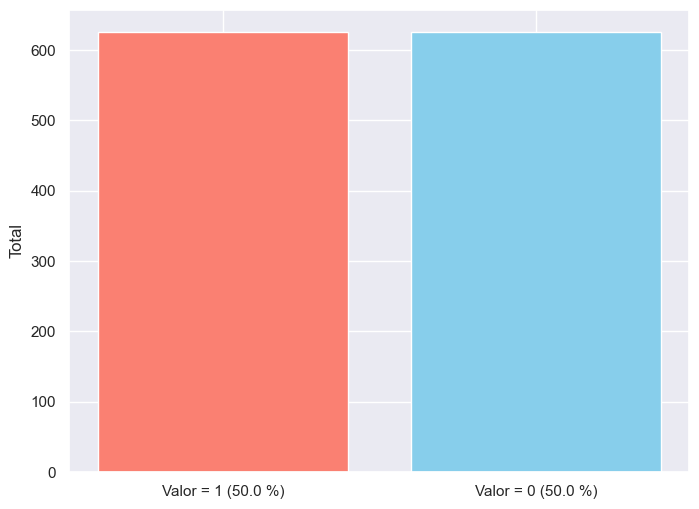

In [1631]:
grafico_barras_binarias('Ataque_cardiaco',df_train_under)

### 3. Oversampling

In [1632]:
df_class_1_over = df_class_1.sample(count_class_0,random_state=1206,replace=True)

print('Total Filas')
print('  Clase 0 - Normal:',df_class_0.shape[0])
print('  Clase 1 - Oversampling:',df_class_1_over.shape[0])

Total Filas
  Clase 0 - Normal: 34094
  Clase 1 - Oversampling: 34094


In [1633]:
# hay un riesgo de que algunas filas no sean consideradas porque la aletoriedad las ignorara
df_train_over = pd.concat([df_class_0, df_class_1_over], axis=0)

print('Total Filas:', df_train_over.shape[0])

Total Filas: 68188


                 Frecuencia  Porcentaje (%)
Ataque_cardiaco                            
0                     34094            50.0
1                     34094            50.0


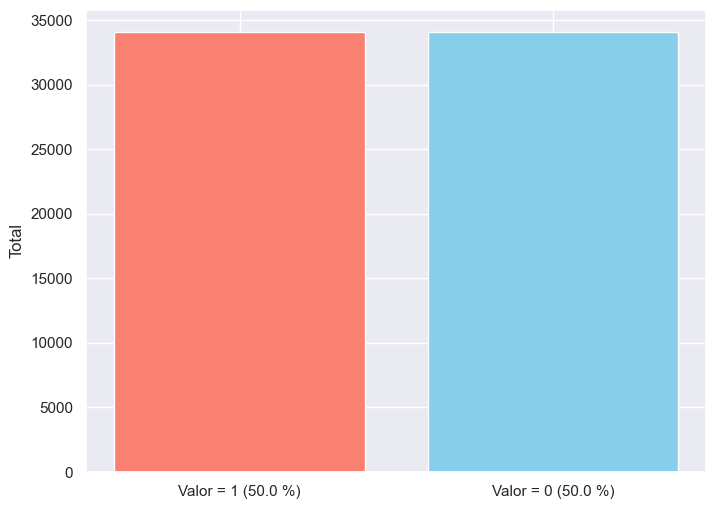

In [1634]:
grafico_barras_binarias('Ataque_cardiaco',df_train_over)

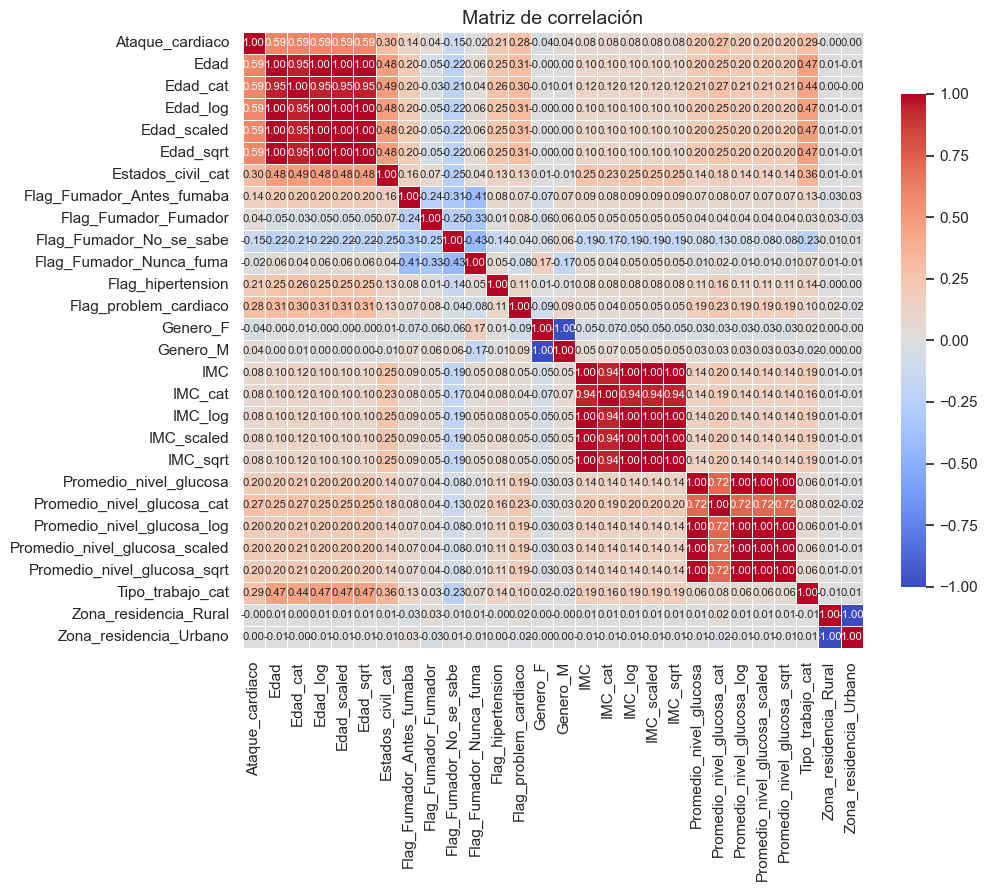

In [1659]:
# Volvemos a evaluar la matriz de correlación con la variable objetivo ya balanceada
corr = df_train_over[['Ataque_cardiaco'] + [c for c in sorted(df_train_over.columns) if c != 'Ataque_cardiaco']].corr(numeric_only=True,method='spearman')

plt.figure(figsize=(10,8))
sns.heatmap(
    corr,
    annot=True,           
    cmap='coolwarm',     
    center=0,           
    fmt=".2f",          
    linewidths=0.5,      
    cbar_kws={'shrink': 0.8},
    annot_kws={"size": 8},   
    xticklabels=True,
    yticklabels=True
)
plt.title('Matriz de correlación', fontsize=14)
plt.show()

**Insights**

Con la información ya balanceada, podemos concluir lo siguiente:
- Las correlaciones bajas que se apreciaban en la matriz anterior se pueden apreciar mejor en este nuevo dataset. Esto debido a que el desbalance de datos hace que nuestra variable objetivo se vea muy poco afectada al solo tener el 2% de casos positivos.
- Es mucho más apreciable el impacto de la **Edad** con respecto a los ataques cardiacos.
- No se aprecian diferencias considerables entre los tipos de Edad transformadas y categorizadas (manteniéndose todas en 0.59)
- La variable **Edad** tiene una correlación moderadamente alta con las variables: **Tipo de Trabajo** y **Estado Civil**.
  - Dentro de la variable Tipo de Trabajo, son los emprendedores el grupo con el mayor riesgo de ataque cardiaco. Esto podría explicarse debido a la tensión que genera el gestionar su propio emprendimiento.
  - Luego sigue el grupo de trabajadores de oficina (privado y gubernamental). Los trabajos de oficina suelen estar ligados a una vida sedentaria, por lo que **puede explicar la correlación de 0.25 con el IMC**.
  - El **Estado Civil** también tiene un impacto en los ataques cardiagos 
- Asimismo, tiene correlaciones significativas con la variable de **Hipertensión** y **Problema cardiaco previo**.
- las variables de **Genero**, **IMC** y **Zona de Residencia** tienen un impacto irrelevante en nuestra variable objetivo, por lo que podremos optar por descartarlas.
- El nivel de **Glucosa** tiene una leve correlación. Correspondería determinar con test como el VIF si corresponde incluirla o no en el modelo. 

### 4. Selección de Variables

Para este análisis, nos quedaremos con las variables categorizadas, para priorizar la interpretabilidad del modelo, además de las variables flag (hipertension y problema cardiaco)

In [1636]:
cols_prueba = [c for c in df_train_over.columns if c.endswith('_cat')] + ['Flag_hipertension','Flag_problem_cardiaco']
cols_prueba

['Estados_civil_cat',
 'Tipo_trabajo_cat',
 'Edad_cat',
 'IMC_cat',
 'Promedio_nivel_glucosa_cat',
 'Flag_hipertension',
 'Flag_problem_cardiaco']

### 4.1. SelectKBest

In [1637]:
# Aplicar SelectKBest para elegir las mejores vairables del modelo
X = df_train_over[cols_prueba]
y = df_train_over['Ataque_cardiaco']

# Seleccionar las 5 mejores variables
selector = SelectKBest(score_func=f_classif, k=5)
X_selected = selector.fit_transform(X, y)

# Ver nombres de las variables seleccionadas
cols_selected = list(X.columns[selector.get_support()])

print(cols_selected)

['Estados_civil_cat', 'Tipo_trabajo_cat', 'Edad_cat', 'Promedio_nivel_glucosa_cat', 'Flag_problem_cardiaco']


**Hallazgo**
- En esta primera prueba, SelectKBest ha descartado las variables anteriormente marcadas como irrelevantes (IMC, Zona_Residencia, Genero)
- Asimismo, ha descartado la variable de hipertensión y ha priorizado el **Flag_problem_cardiaco**.

### 4.2. VIF

In [1638]:
X = train[cols_prueba]
X = sm.add_constant(X)

vif_df = pd.DataFrame({
    'Variable': X.columns,
    'VIF': [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
})
print(vif_df.sort_values(by='VIF',ascending=False))

                     Variable        VIF
0                       const  16.008613
3                    Edad_cat   1.933333
1           Estados_civil_cat   1.763020
2            Tipo_trabajo_cat   1.468633
4                     IMC_cat   1.160959
5  Promedio_nivel_glucosa_cat   1.111665
6           Flag_hipertension   1.098253
7       Flag_problem_cardiaco   1.089774


**Hallazgo**
- El test de VIF nos indica que ninguna de las variables incurre en un problema de colinealidad.
- Teniendo los resultados del VIF y de SelectKBest, optaremos con entrenar, de manera preliminar, con las 5 variables previamente indicadas.

In [1639]:
cols_modelo = cols_selected.copy()

## 5. Entrenamiento del Modelo

In [1640]:
def evaluar_modelos(X_train, y_train, X_test, y_test, modelos: dict, umbral=0.5, mostrar_matriz=False):

    resultados = {
        'Model': [],
        'Accuracy_train': [],
        'Accuracy_test': [],
        'Recall_train': [],
        'Recall_test': [],
        'Precision_train': [],
        'Precision_test': [],
        'F1_train': [],
        'F1_test': [],
        'AUC_train': [],
        'AUC_test': [],
        'CV_Mean_Score': [],
        'Time_Sec': [],
        'Time_Min': []
    }

    for nombre, modelo in modelos.items():
        print(f"\n🔹 Entrenando modelo: {nombre}...")
        inicio = time()

        modelo.fit(X_train, y_train)

        # Cross-validation
        cv_scores = cross_val_score(modelo, X_train, y_train, cv=5, scoring='recall')

        # Predicciones probabilísticas y binarias
        y_train_prob = modelo.predict_proba(X_train)[:, 1]
        y_test_prob = modelo.predict_proba(X_test)[:, 1]

        y_train_pred = (y_train_prob > umbral).astype(int)
        y_test_pred = (y_test_prob > umbral).astype(int)
        y_train_proba = modelo.predict_proba(X_train)[:, 1]
        y_test_proba  = modelo.predict_proba(X_test)[:, 1]

        # Métricas
        acc_train = accuracy_score(y_train, y_train_pred)
        acc_test = accuracy_score(y_test, y_test_pred)
        rec_train = recall_score(y_train, y_train_pred)
        rec_test = recall_score(y_test, y_test_pred)
        prec_train = precision_score(y_train, y_train_pred)
        prec_test = precision_score(y_test, y_test_pred)
        f1_train = f1_score(y_train, y_train_pred)
        f1_test = f1_score(y_test, y_test_pred)
        auc_train = roc_auc_score(y_train, y_train_proba)
        auc_test  = roc_auc_score(y_test, y_test_proba)

        final = time()
        time_sec = round(final - inicio, 2)
        time_min = round(time_sec / 60, 2)

        resultados['Model'].append(nombre)
        resultados['Accuracy_train'].append(acc_train)
        resultados['Accuracy_test'].append(acc_test)
        resultados['Recall_train'].append(rec_train)
        resultados['Recall_test'].append(rec_test)
        resultados['Precision_train'].append(prec_train)
        resultados['Precision_test'].append(prec_test)
        resultados['F1_train'].append(f1_train)
        resultados['F1_test'].append(f1_test)
        resultados['AUC_train'].append(auc_train)
        resultados['AUC_test'].append(auc_test)
        resultados['CV_Mean_Score'].append(cv_scores.mean())
        resultados['Time_Sec'].append(time_sec)
        resultados['Time_Min'].append(time_min)

        # Matriz de confusión opcional
        if mostrar_matriz:
            cm = confusion_matrix(y_test, y_test_pred, labels=[0, 1])
            df_cm = pd.DataFrame(cm, index=["Real - No", "Real - Sí"], columns=["Pred - No", "Pred - Sí"])
            
            plt.figure(figsize=(6, 4))
            sns.heatmap(df_cm, annot=True, fmt='d', cmap='Blues')
            plt.title(f"Matriz de confusión - {nombre}")
            plt.ylabel("Etiqueta real")
            plt.xlabel("Predicción")
            plt.show()

    return pd.DataFrame(resultados).sort_values(by='Recall_test', ascending=False).reset_index(drop=True)

Para este problema, vamos a definir como métrica principal el **Recall**.

Esto debido a que lo que buscamos es mitigar el impacto de **falsos negativos**: Es decir, dar como sano a un cliente que tiene un riesgo potencial de sufrir un ataque cardiaco.

No obstante, se van a tomar en consideración las mediciones de **Accuracy**, **Precision** y **F1 Score** para revisar posible sobreajuste del modelo.

In [1641]:
modelos = {
        "Decision Tree": DecisionTreeClassifier(max_depth=5, random_state=42),
        "Random Forest": RandomForestClassifier(n_estimators=100, random_state=42, max_depth=5),
        "Gradient Boosting": GradientBoostingClassifier(random_state=42, max_depth=5),
        "AdaBoost": AdaBoostClassifier(random_state=42, n_estimators=50, learning_rate=0.05),
        "XGBoost": XGBClassifier(n_estimators=100, random_state=42, verbosity=0, max_depth=5, learning_rate=0.05),
        "LightGBM": LGBMClassifier(n_estimators=100, random_state=42, max_depth=5, learning_rate=0.05)
}

### 5.1. Dataset sin Balance

In [1642]:
# Separar el train del test
X_train = train[cols_modelo]
y_train = train['Ataque_cardiaco']
X_test = test[cols_modelo]
y_test = test['Ataque_cardiaco']

In [1643]:
X_train.columns

Index(['Estados_civil_cat', 'Tipo_trabajo_cat', 'Edad_cat',
       'Promedio_nivel_glucosa_cat', 'Flag_problem_cardiaco'],
      dtype='object')


🔹 Entrenando modelo: Decision Tree...


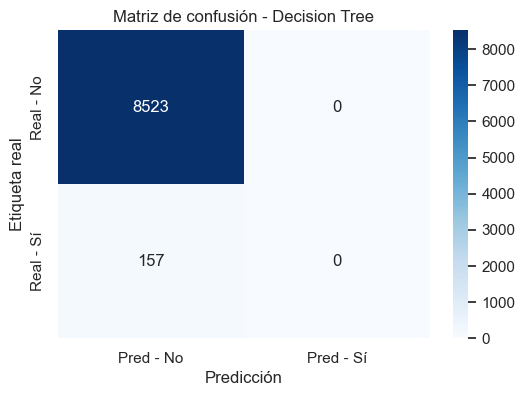


🔹 Entrenando modelo: Random Forest...


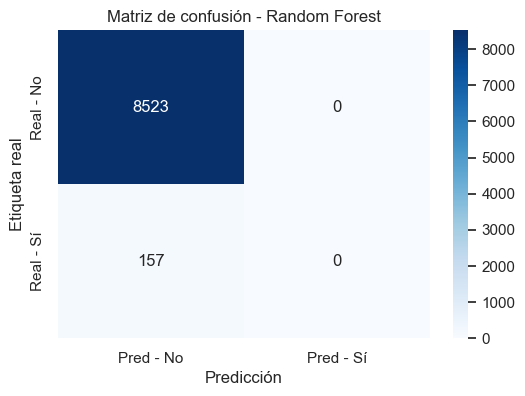


🔹 Entrenando modelo: Gradient Boosting...


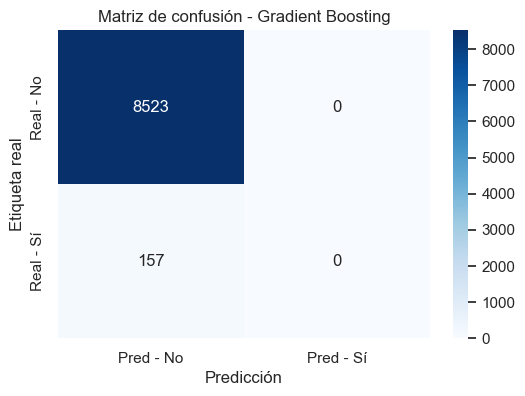


🔹 Entrenando modelo: AdaBoost...


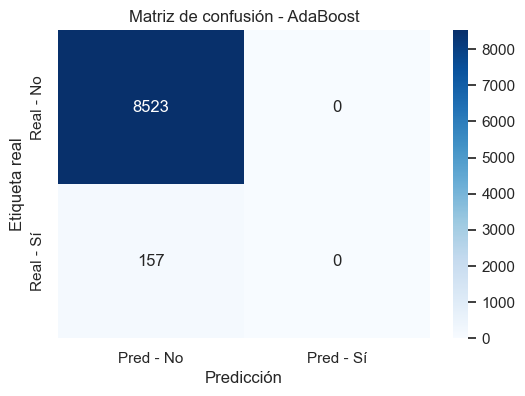


🔹 Entrenando modelo: XGBoost...


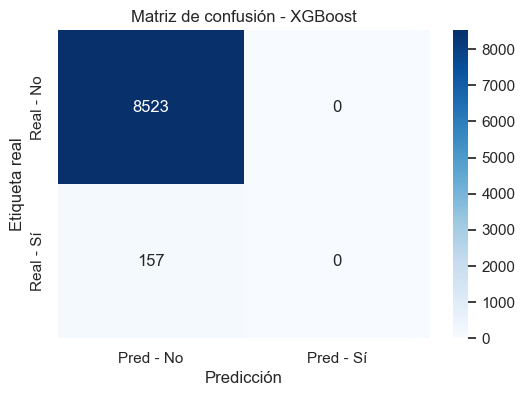


🔹 Entrenando modelo: LightGBM...
[LightGBM] [Info] Number of positive: 626, number of negative: 34094
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000699 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 15
[LightGBM] [Info] Number of data points in the train set: 34720, number of used features: 5
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.018030 -> initscore=-3.997526
[LightGBM] [Info] Start training from score -3.997526
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits

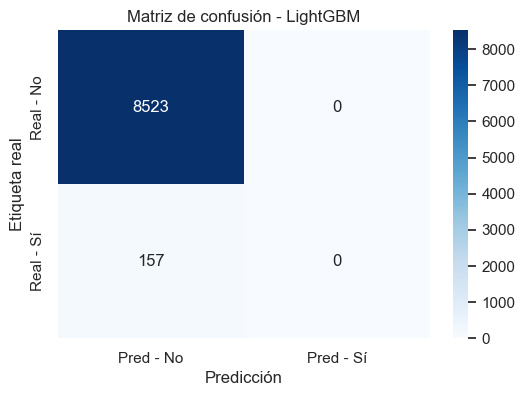

,Model,Accuracy_train,Accuracy_test,Recall_train,Recall_test,Precision_train,Precision_test,F1_train,F1_test,AUC_train,AUC_test,CV_Mean_Score,Time_Sec,Time_Min
0,Decision Tree,0.981970,0.981912,0.000000,0.0,0.0,0.0,0.00000,0.0,0.854016,0.823235,0.0,0.18,0.00
1,Random Forest,0.981970,0.981912,0.000000,0.0,0.0,0.0,0.00000,0.0,0.851551,0.825781,0.0,4.39,0.07
2,Gradient Boosting,0.981999,0.981912,0.001597,0.0,1.0,0.0,0.00319,0.0,0.855353,0.821703,0.0,8.39,0.14
3,AdaBoost,0.981970,0.981912,0.000000,0.0,0.0,0.0,0.00000,0.0,0.845503,0.826919,0.0,4.77,0.08
4,XGBoost,0.981970,0.981912,0.000000,0.0,0.0,0.0,0.00000,0.0,0.854071,0.822126,0.0,1.05,0.02
5,LightGBM,0.981970,0.981912,0.000000,0.0,0.0,0.0,0.00000,0.0,0.854759,0.821990,0.0,0.77,0.01


In [1644]:
evaluar_modelos(X_train=X_train,
                y_train=y_train,
                X_test=X_test,
                y_test=y_test,
                modelos=modelos,
                mostrar_matriz=True)

**Hallazgos**
- Los resultados del dataset sin balanceo de dato nos indican que el **Recall test** es igual a 0.
- El modelo ha aprendido tanto de la clase mayoritaria que no puede distinguir un caso positivo.
- Esto es esperable al tratar con un dataset tan desbalanceado (98 a 2%, aproximadamente)
- La validación cruzada nos da 0 en todos los modelos.

### 5.2. Dataset con Undersampling

In [1645]:
# Separar el train del test
X_train = df_train_under[cols_modelo]
y_train = df_train_under['Ataque_cardiaco']
X_test = test[cols_modelo]
y_test = test['Ataque_cardiaco']


🔹 Entrenando modelo: Decision Tree...


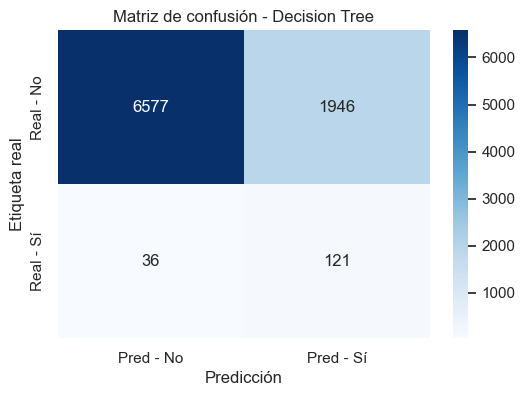


🔹 Entrenando modelo: Random Forest...


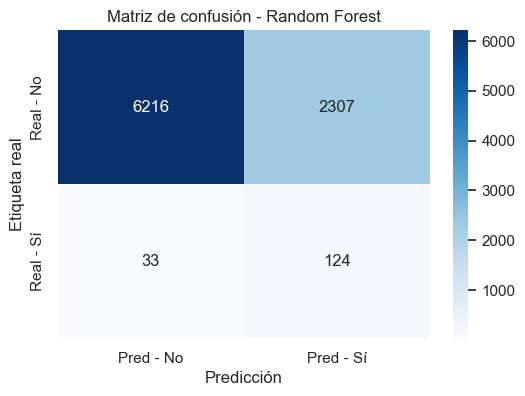


🔹 Entrenando modelo: Gradient Boosting...


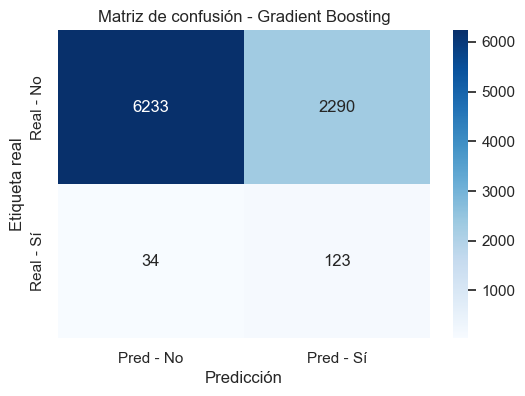


🔹 Entrenando modelo: AdaBoost...


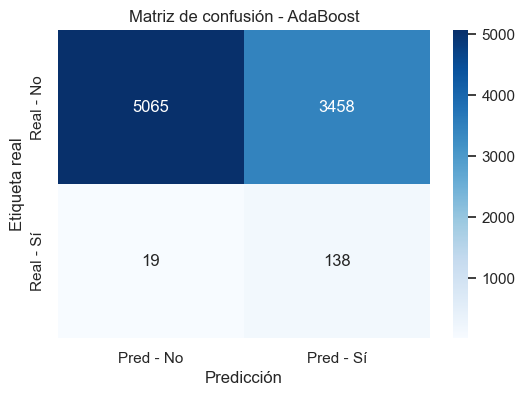


🔹 Entrenando modelo: XGBoost...


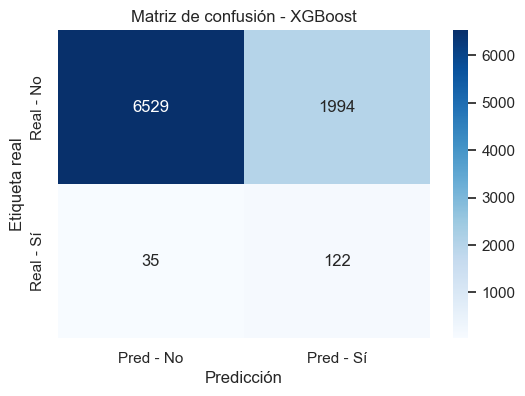


🔹 Entrenando modelo: LightGBM...
[LightGBM] [Info] Number of positive: 626, number of negative: 626
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000084 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 15
[LightGBM] [Info] Number of data points in the train set: 1252, number of used features: 5
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] 

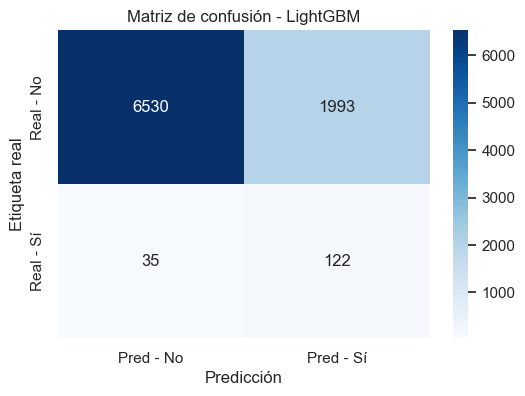

,Model,Accuracy_train,Accuracy_test,Recall_train,Recall_test,Precision_train,Precision_test,F1_train,F1_test,AUC_train,AUC_test,CV_Mean_Score,Time_Sec,Time_Min
0,AdaBoost,0.772364,0.599424,0.924920,0.878981,0.708690,0.038376,0.802495,0.073541,0.856062,0.825791,0.924978,0.81,0.01
1,Random Forest,0.785942,0.730415,0.822684,0.789809,0.766369,0.051008,0.793529,0.095827,0.868821,0.823468,0.827543,1.04,0.02
2,Gradient Boosting,0.786741,0.732258,0.825879,0.783439,0.765926,0.050974,0.794773,0.095720,0.872000,0.817079,0.781181,1.59,0.03
3,XGBoost,0.784345,0.766244,0.785942,0.777070,0.783439,0.057656,0.784689,0.107347,0.868915,0.820854,0.793994,0.52,0.01
4,LightGBM,0.784345,0.766359,0.785942,0.777070,0.783439,0.057683,0.784689,0.107394,0.865427,0.823228,0.798794,0.26,0.00
5,Decision Tree,0.785942,0.771659,0.784345,0.770701,0.786859,0.058539,0.785600,0.108813,0.865863,0.812803,0.782806,0.08,0.00


In [1646]:
evaluar_modelos(X_train=X_train,
                y_train=y_train,
                X_test=X_test,
                y_test=y_test,
                modelos=modelos,
                mostrar_matriz=True)

**Hallazgos**
- Con el dataset con undersampling, se detecta que el **Recall_test** es bastante alto (un 87.9%).
- Por otro lado, nuestro modelo tiene un **Precision_test** extremadamente bajo, lo que nos indica que identifica muchos falsos positivos.
- Este comportamiento se ve reflejado en los demás modelos. Ningún modelo supera el 6% de Precision.
- En la validación cruzada, tenemos valores muy altos y estables en **Recall_test**, lo que descartaría el sobreajuste.

### 5.3. Dataset con Oversampling

In [1647]:
# Separar el train del test
X_train = df_train_over[cols_modelo]
y_train = df_train_over['Ataque_cardiaco']
X_test = test[cols_modelo]
y_test = test['Ataque_cardiaco']


🔹 Entrenando modelo: Decision Tree...


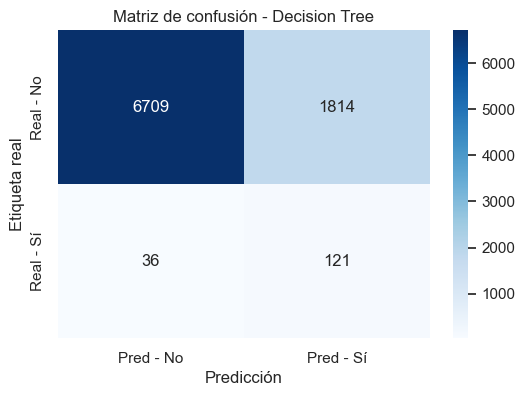


🔹 Entrenando modelo: Random Forest...


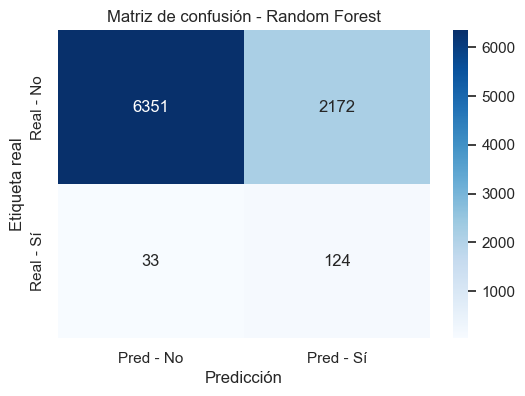


🔹 Entrenando modelo: Gradient Boosting...


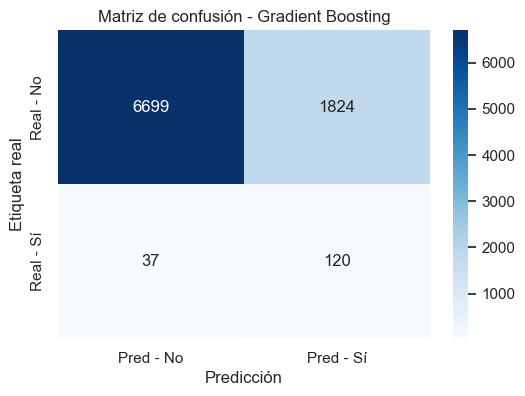


🔹 Entrenando modelo: AdaBoost...


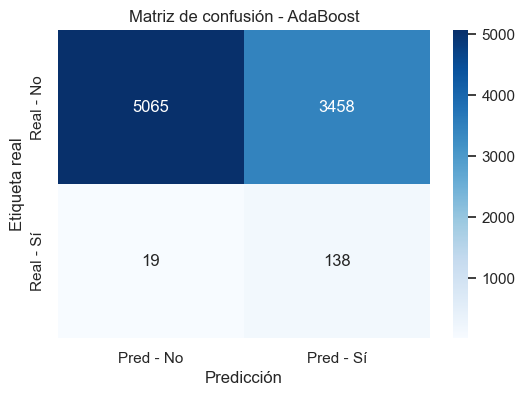


🔹 Entrenando modelo: XGBoost...


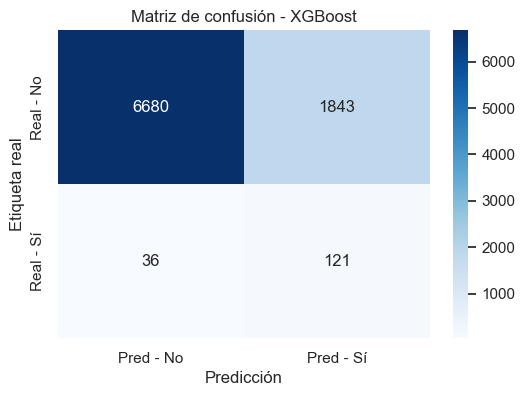


🔹 Entrenando modelo: LightGBM...
[LightGBM] [Info] Number of positive: 34094, number of negative: 34094
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001253 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 15
[LightGBM] [Info] Number of data points in the train set: 68188, number of used features: 5
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warn

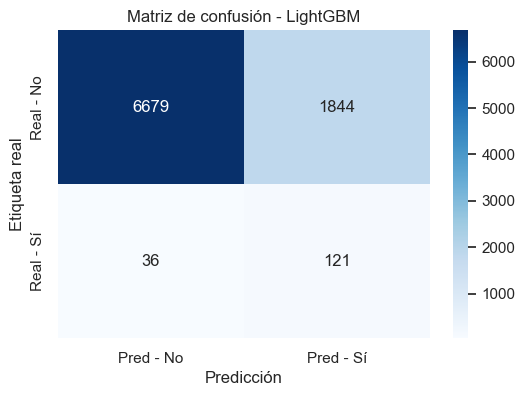

,Model,Accuracy_train,Accuracy_test,Recall_train,Recall_test,Precision_train,Precision_test,F1_train,F1_test,AUC_train,AUC_test,CV_Mean_Score,Time_Sec,Time_Min
0,AdaBoost,0.761072,0.599424,0.924591,0.878981,0.696733,0.038376,0.794651,0.073541,0.844918,0.826919,0.924591,6.67,0.11
1,Random Forest,0.778744,0.745968,0.810905,0.789809,0.761898,0.054007,0.785638,0.101101,0.852629,0.825508,0.795273,7.68,0.13
2,Decision Tree,0.780167,0.786866,0.772013,0.770701,0.784811,0.062532,0.778359,0.115679,0.853810,0.819624,0.785770,0.33,0.01
3,XGBoost,0.782146,0.783525,0.778583,0.770701,0.784172,0.061609,0.781367,0.114097,0.854904,0.822105,0.778583,0.69,0.01
4,LightGBM,0.782014,0.783410,0.778583,0.770701,0.783963,0.061578,0.781264,0.114043,0.854782,0.822031,0.778583,0.76,0.01
5,Gradient Boosting,0.782249,0.785599,0.776794,0.764331,0.785363,0.061728,0.781055,0.114231,0.855399,0.821304,0.778847,16.50,0.28


In [1648]:
evaluar_modelos(X_train=X_train,
                y_train=y_train,
                X_test=X_test,
                y_test=y_test,
                modelos=modelos,
                mostrar_matriz=True)

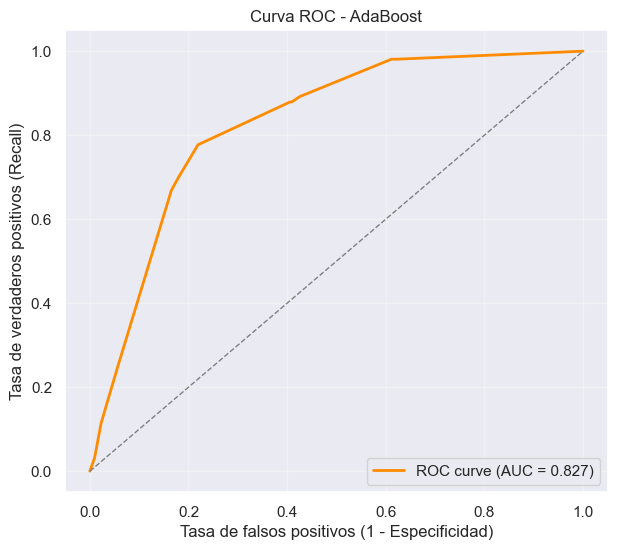

In [1649]:
# Obtener probabilidades de clase positiva
y_proba = modelos['AdaBoost'].predict_proba(X_test)[:, 1]

# Calcular puntos (FPR, TPR) y el AUC
fpr, tpr, thresholds = roc_curve(y_test, y_proba)
roc_auc = auc(fpr, tpr)

# Gráfico manual (más personalizable)
plt.figure(figsize=(7, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.3f})')
plt.plot([0, 1], [0, 1], color='gray', lw=1, linestyle='--')
plt.xlabel('Tasa de falsos positivos (1 - Especificidad)')
plt.ylabel('Tasa de verdaderos positivos (Recall)')
plt.title('Curva ROC - AdaBoost')
plt.legend(loc="lower right")
plt.grid(alpha=0.3)
plt.show()

**Hallazgos**
- Los resultados de la evaluación del dataset con oversampling son muy similares a los resultados con undersampling (**Recall en test** muy bueno y un **Precision_test** muy bajo)
- Es ligeramente mayor el precision que en el dataset con undersampling, aunque sigue siendo bastante bajo. 
- En los dos casos podemos afirmar que el modelo no reconoce bien los falsos positivos, sin embargo, es bastante bueno para identificar los falsos negativos (nuestra métrica a priorizar)
- Por otro lado, el ROC-AUC es de 0.827, lo que nos habla de un modelo que tiene un buen nivel para discriminar los positivos de los negativos.

### Optimización de Hiperparámetros

In [1650]:
def objective(trial):
    # Espacio de búsqueda de hiperparámetros
    n_estimators = trial.suggest_int("n_estimators", 50, 500)
    learning_rate = trial.suggest_float("learning_rate", 0.001, 1.0, log=True)
    max_depth = trial.suggest_int("max_depth", 3, 12)

    # Modelo base
    base_estimator = DecisionTreeClassifier(
        max_depth=max_depth,
        random_state=42
    )

    # Modelo principal
    model = AdaBoostClassifier(
        estimator=base_estimator,
        n_estimators=n_estimators,
        learning_rate=learning_rate,
        random_state=42
    )

    # Validación cruzada estratificada
    cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    recall_scorer = make_scorer(recall_score)

    # Puntajes de validación cruzada
    scores = cross_val_score(model, X_train, y_train, cv=cv, scoring=recall_scorer)

    return np.mean(scores)

In [1651]:
# Tomamos como base el dataset con Oversamplint
X_train = df_train_over[cols_modelo]
y_train = df_train_over['Ataque_cardiaco']
X_test = test[cols_modelo]
y_test = test['Ataque_cardiaco']

In [1652]:
# Optimizar
study = optuna.create_study(direction="maximize", study_name="AdaBoost_Optuna")
study.optimize(objective, n_trials=50, n_jobs=-1)

print("Mejores hiperparámetros encontrados:")
print(study.best_params)
print(f"Mejor Recall promedio (CV): {study.best_value:.4f}")

[I 2025-11-04 00:26:16,342] A new study created in memory with name: AdaBoost_Optuna
[I 2025-11-04 00:26:31,972] Trial 7 finished with value: 0.7785532727370261 and parameters: {'n_estimators': 50, 'learning_rate': 0.45720941533065507, 'max_depth': 7}. Best is trial 7 with value: 0.7785532727370261.
[I 2025-11-04 00:26:36,244] Trial 1 finished with value: 0.7782892312822727 and parameters: {'n_estimators': 61, 'learning_rate': 0.0029676865103854446, 'max_depth': 4}. Best is trial 7 with value: 0.7785532727370261.
[I 2025-11-04 00:26:56,735] Trial 3 finished with value: 0.7785532727370261 and parameters: {'n_estimators': 117, 'learning_rate': 0.013601383900062268, 'max_depth': 11}. Best is trial 7 with value: 0.7785532727370261.
[I 2025-11-04 00:26:57,373] Trial 0 finished with value: 0.7785532727370261 and parameters: {'n_estimators': 119, 'learning_rate': 0.01593478887525332, 'max_depth': 6}. Best is trial 7 with value: 0.7785532727370261.
[I 2025-11-04 00:27:01,124] Trial 17 finished

Mejores hiperparámetros encontrados:
{'n_estimators': 166, 'learning_rate': 0.14132887604006922, 'max_depth': 3}
Mejor Recall promedio (CV): 0.7833


In [1653]:
# Entrenar modelo final con los mejores parámetros
best_params = study.best_params
best_model = AdaBoostClassifier(
    estimator=DecisionTreeClassifier(max_depth=best_params["max_depth"], random_state=42),
    n_estimators=best_params["n_estimators"],
    learning_rate=best_params["learning_rate"],
    random_state=42
)

best_model.fit(X_train, y_train)

AdaBoostClassifier(estimator=DecisionTreeClassifier(max_depth=3,
                                                    random_state=42),
                   learning_rate=0.14132887604006922, n_estimators=166,
                   random_state=42)


🔹 Entrenando modelo: AdaBoost_Tuned...


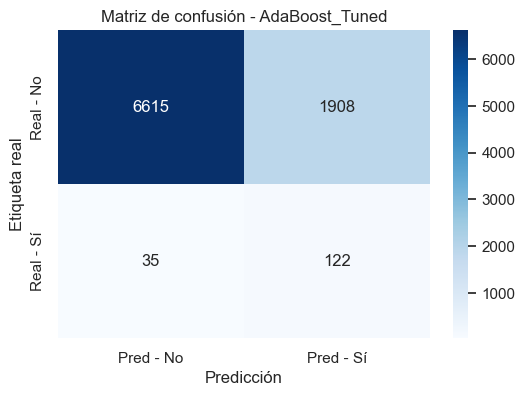

,Model,Accuracy_train,Accuracy_test,Recall_train,Recall_test,Precision_train,Precision_test,F1_train,F1_test,AUC_train,AUC_test,CV_Mean_Score,Time_Sec,Time_Min
0,AdaBoost_Tuned,0.780475,0.776152,0.7831,0.77707,0.77901,0.060099,0.781049,0.111568,0.854592,0.822545,0.78222,27.68,0.46


In [1654]:
evaluar_modelos(X_train=X_train,
                y_train=y_train,
                X_test=X_test,
                y_test=y_test,
                modelos={'AdaBoost_Tuned':best_model},
                mostrar_matriz=True)

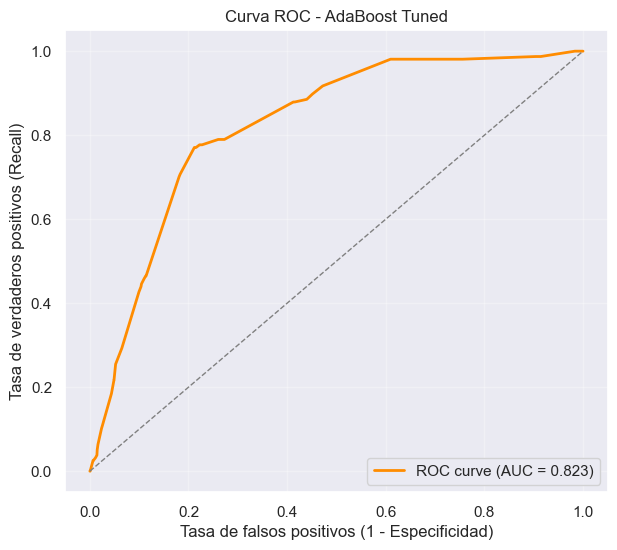

In [1655]:
# Obtener probabilidades de clase positiva
y_proba = best_model.predict_proba(X_test)[:, 1]

# Calcular puntos (FPR, TPR) y el AUC
fpr, tpr, thresholds = roc_curve(y_test, y_proba)
roc_auc = auc(fpr, tpr)

# Gráfico manual (más personalizable)
plt.figure(figsize=(7, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.3f})')
plt.plot([0, 1], [0, 1], color='gray', lw=1, linestyle='--')
plt.xlabel('Tasa de falsos positivos (1 - Especificidad)')
plt.ylabel('Tasa de verdaderos positivos (Recall)')
plt.title('Curva ROC - AdaBoost Tuned')
plt.legend(loc="lower right")
plt.grid(alpha=0.3)
plt.show()

**Hallazgo**
- Según la curva ROC en el test, nuestro modelo **AdaBoost Ajustado** tiene un buen poder para discriminar entre positivos y negativos, incluso considerando el tradeoff con el bajo **precision score**, muy similar al AdaBoost sin ajustar (el mejor modelo sin tuning).

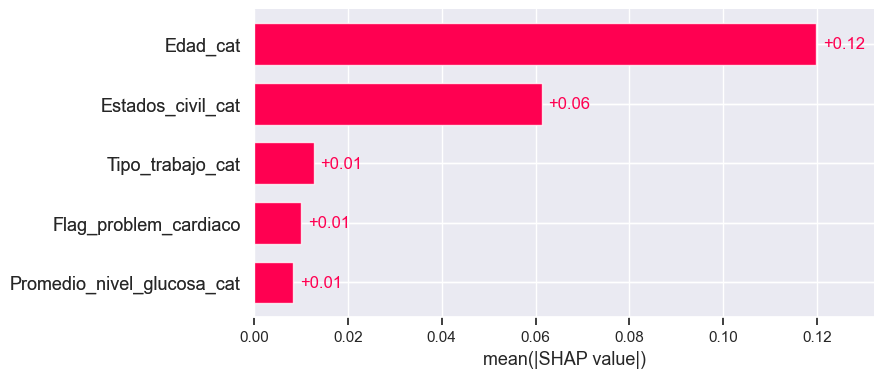

In [1656]:
import shap

# Definir una función que devuelva las probabilidades de la clase positiva
f = lambda X: best_model.predict_proba(X)[:, 1]

# Crear un masker a partir de los datos de entrenamiento
masker = shap.maskers.Independent(X_train)

# Crear el explainer
explainer = shap.Explainer(f, masker)
X_sample = X_test.sample(200, random_state=42)
shap_values = explainer(X_sample)

# Graficar importancia de variables
shap.plots.bar(shap_values)


**Conclusiones**
- El modelo final es bastante bueno para la finalidad que hemos definido previamente: **Reducir el impacto de falsos negativos**. En este caso, no identificar a pacientes con riesgo de ataque cardiaco.
- Los resultados nos indican que es un excelente modelo identificando **falsos negativos** (88% en Recall test), con la desventaja de que levanta falsas alarmas (el precision es muy bajo, rondando el 4%)
- Como estimador principal del modelo, podemos indicar que la **Edad categorizada** es la variable más importante, seguido del Estado Civil.
- Las variables Tipo_trabajo, Problema_Cardiago y Nivel_Glucosa aporta, sin embargo, su impacto es mucho menor.
- Este comportamiento puede deberse a un modelo muy desbalanceado (un desbalance aproximado de 98% vs 2%)
- Como próximos pasos, podemos considerar evaluar la opción de ajustar el umbral (actualmente de 0.5) para quizás no levantar falsas alarmas. Tomando en consideración que esto puede tener un impacto es nuestra métrica principal.
- Es posible ir experimentando con otros modelos ensemble (**Stacking Classifier**) o alguna red neuronal, para mejorar el rendimiento del modelo.
- Para la fase de despliegue, podemos disponibilizar este modelo a través de aplicaciones como Streamlit utilizando servicios cloud (como GCP).